In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
from scipy.optimize import curve_fit
import scipy.optimize as optimize
from sklearn.linear_model import LinearRegression

In [49]:
persons = ['A', 'B', 'C']
nums = [10, 25, 50, 100, 200, 500]
# nums = [10]

delete_list = ['Yindel', 'AMEL', 'DYS391', 'Amel']
reference = pd.read_csv('data/Refrence.csv')
# 计算每个个体的基因座上的等位基因
alleles_dict_list = []
for person in persons:
    A_refrence_data = reference[reference['sample'] == person]
    A_refrence_data = A_refrence_data[~A_refrence_data['marker'].isin(delete_list)]
    alleles_dict = {A_refrence_data['marker']:[A_refrence_data['allele1'],A_refrence_data['allele2']] for index,A_refrence_data in A_refrence_data.iterrows()}
    alleles_dict_list.append(alleles_dict)



/tmp/ipykernel_51506/878370087.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(dpi=300)


{'基因座': ['D3S1358',
  'vWA',
  'D16S539',
  'TPOX',
  'D8S1179',
  'D21S11',
  'D2S441',
  'D19S433',
  'TH01',
  'FGA',
  'D22S1045',
  'D5S818',
  'D13S317',
  'D7S820',
  'SE33',
  'D10S1248',
  'D1S1656',
  'D12S391',
  'D2S1338'],
 '斜率': [0.016249789768774385,
  0.012428638152564668,
  0.007002449108987527,
  0.005949360661159987,
  0.007009400690257616,
  0.0013787171776609777,
  0.00563163204038702,
  0.0028403055313817793,
  0.007698922415915699,
  0.0059189295824877775,
  0.017578345413658613,
  0.02838526366294086,
  0.015209273560211,
  0.012489573774563075,
  0.0014598240360465273,
  0.02004073459132196,
  0.00804847607505363,
  0.009285726449802077,
  0.004662447247074279],
 '截距': [-0.158782043106939,
  -0.14389421862177867,
  -0.01708098018775471,
  -0.011867396129310426,
  -0.031211515433286867,
  -0.006658706131428549,
  -0.02139502945176773,
  0.007830238811158248,
  -0.013473750624270163,
  -0.07628310086656556,
  -0.15634466968774796,
  -0.2037095918668799,
  -0.0792

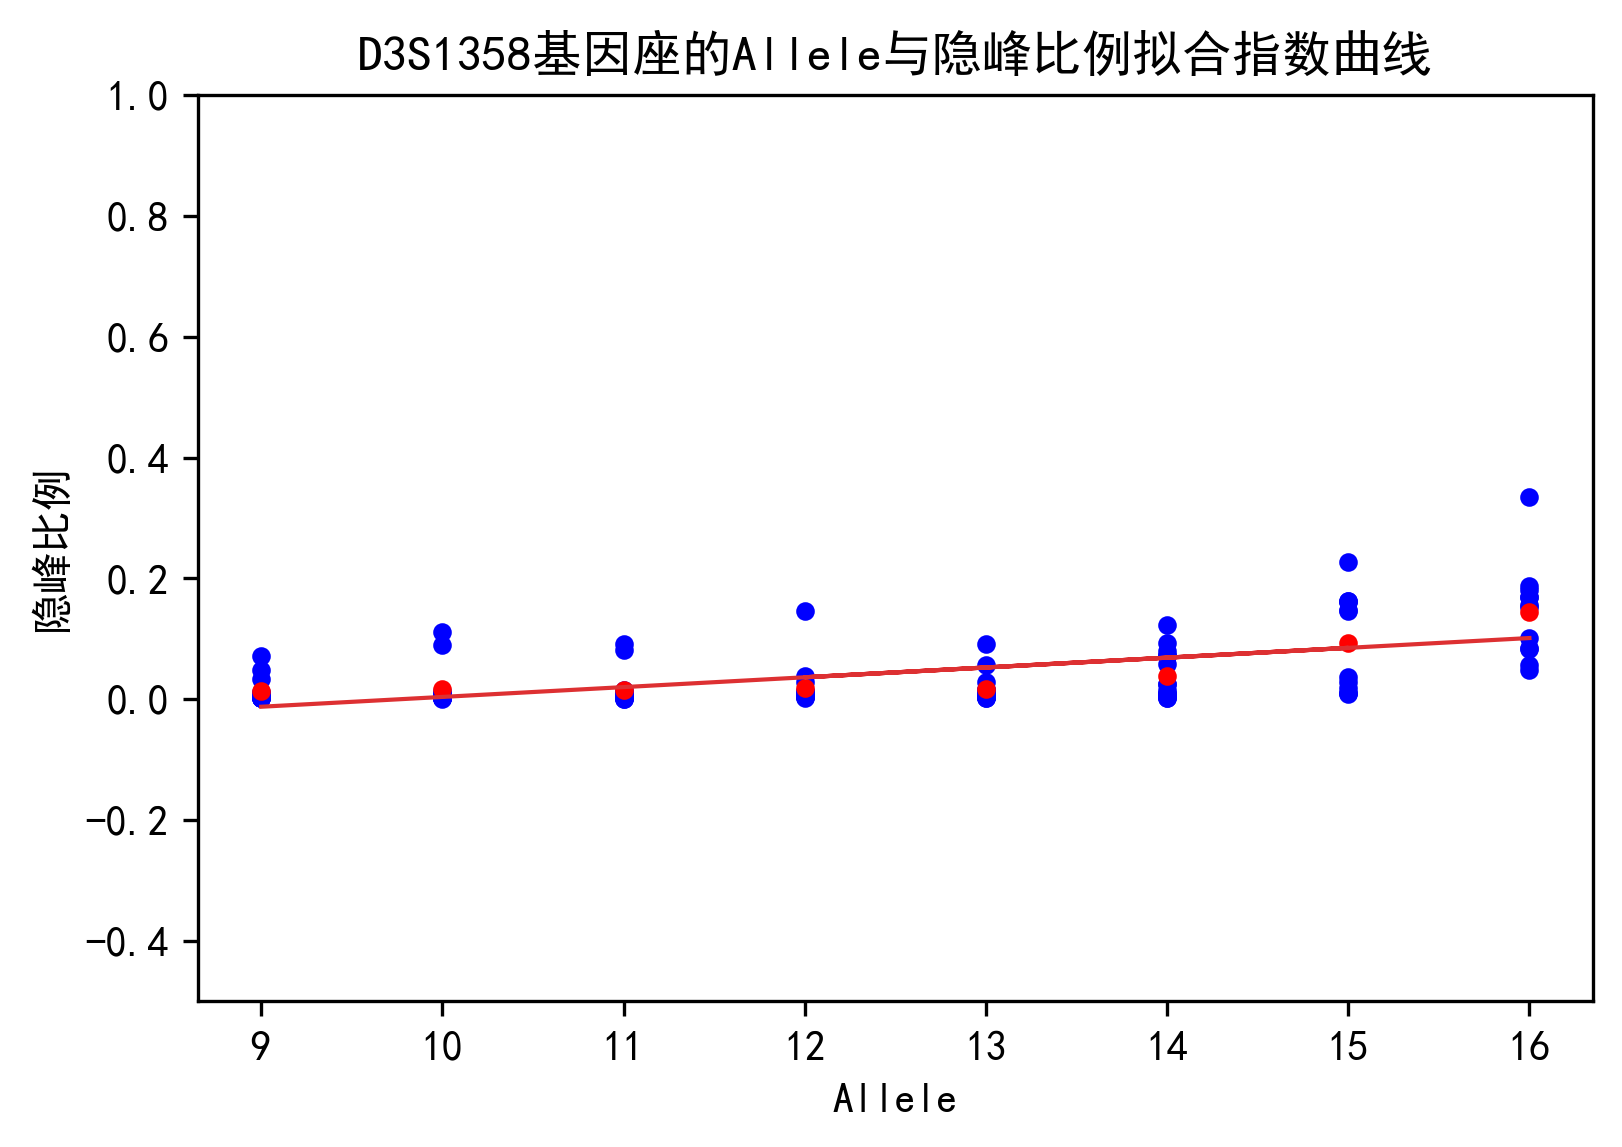

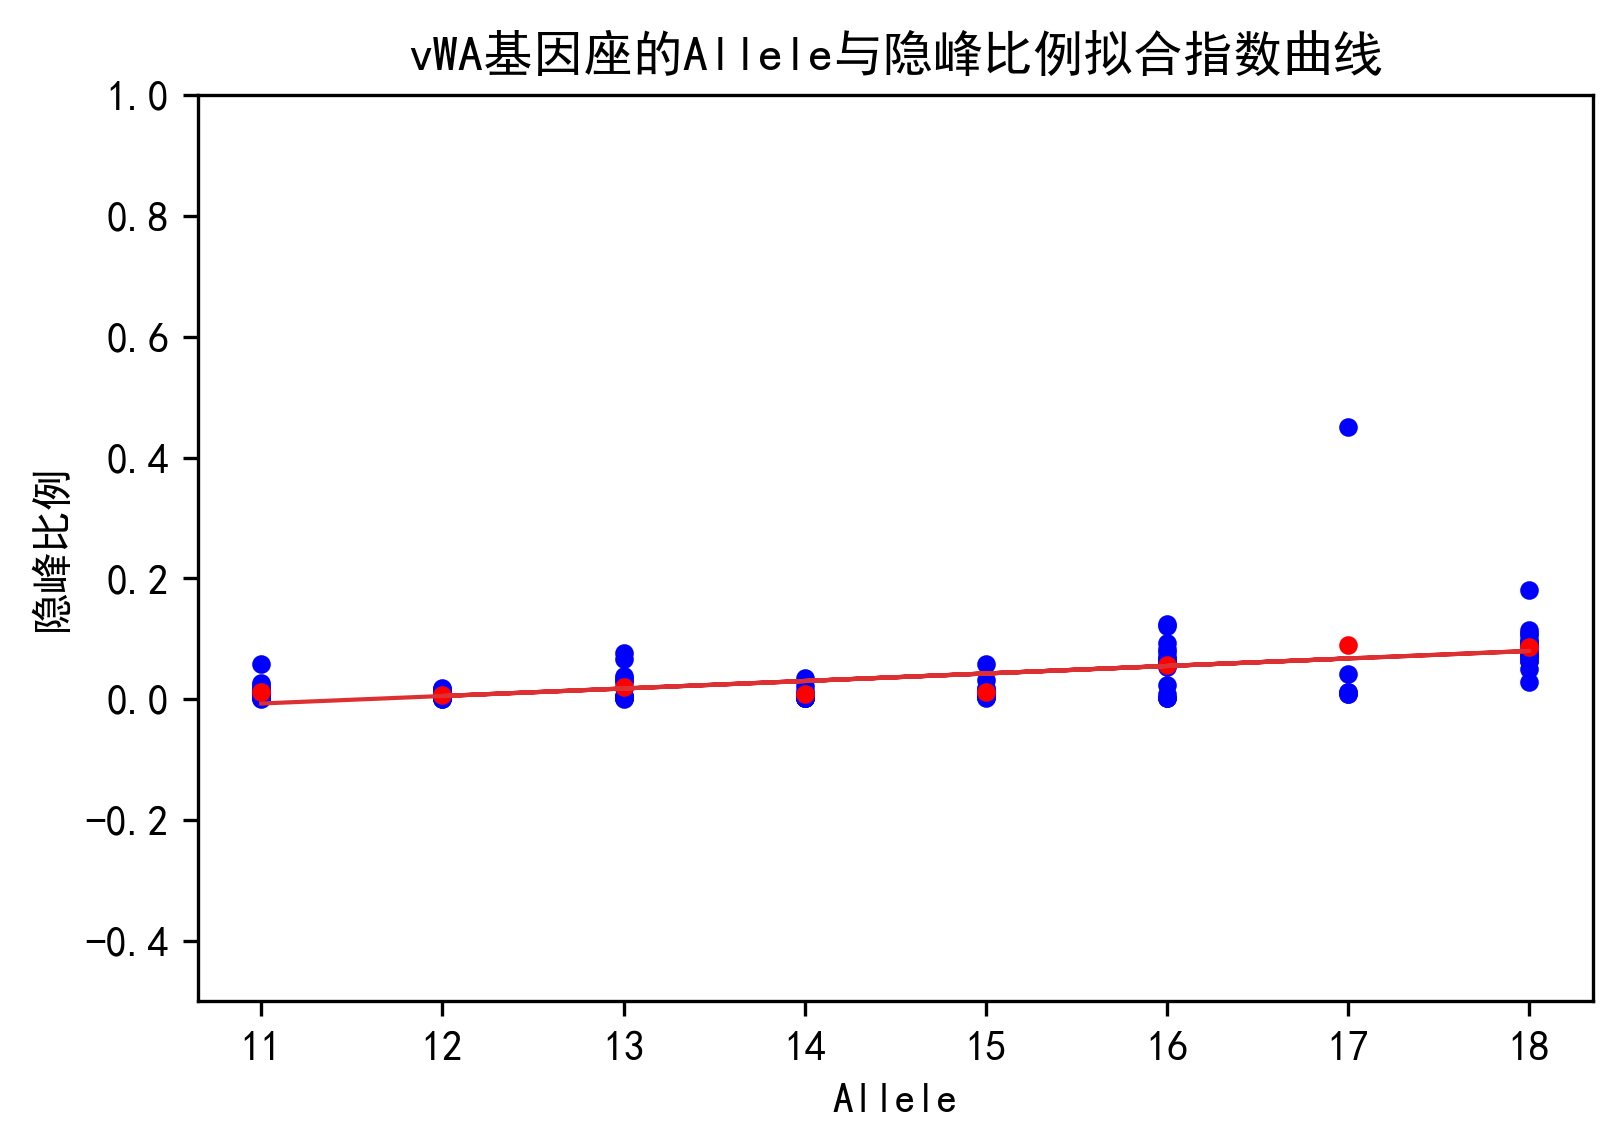

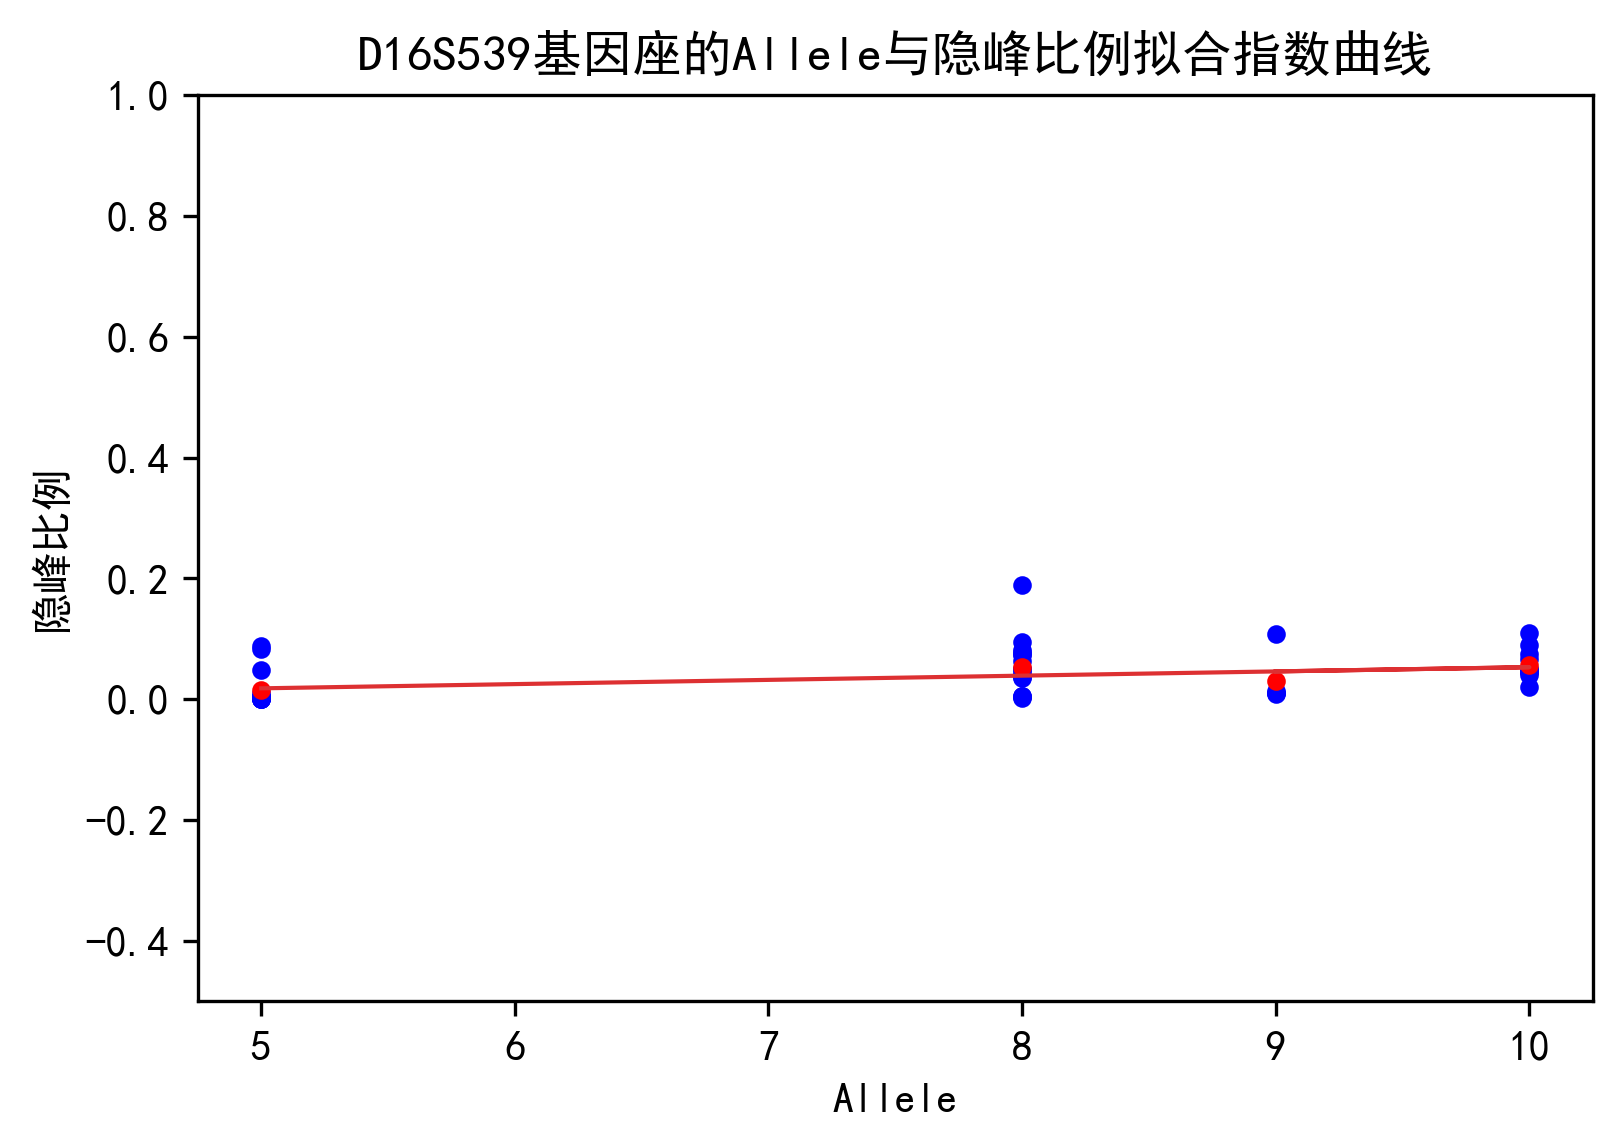

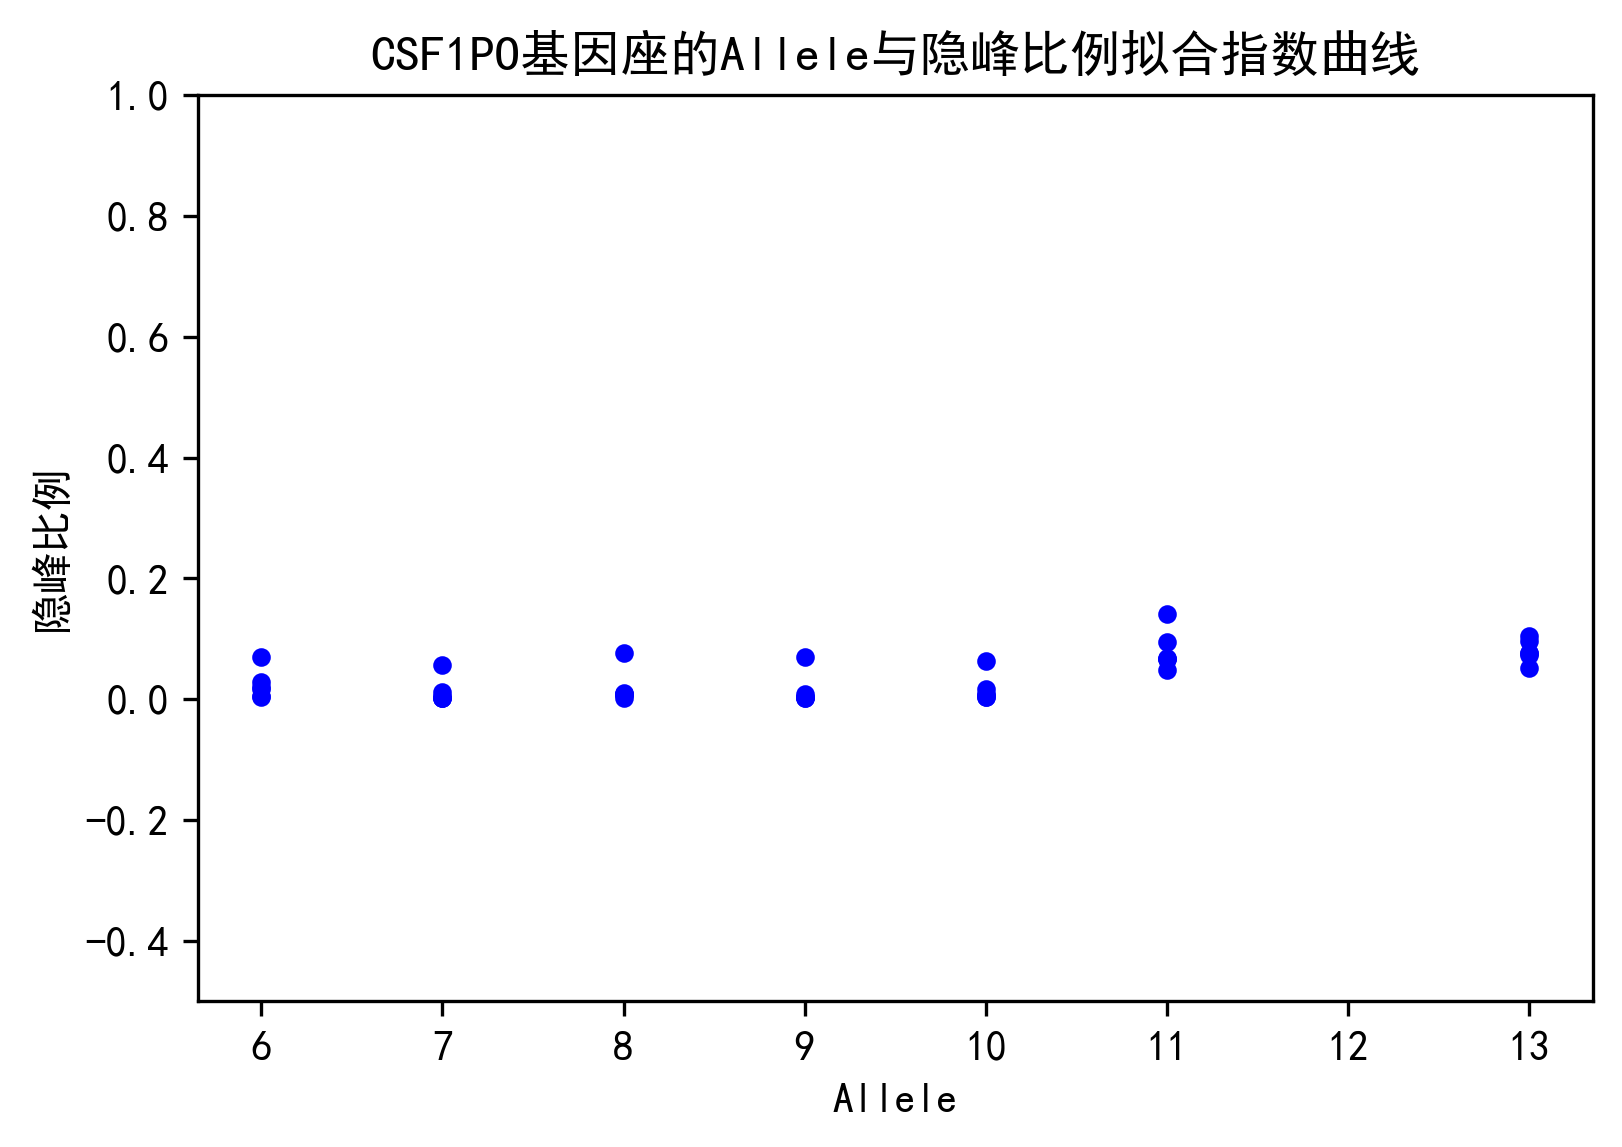

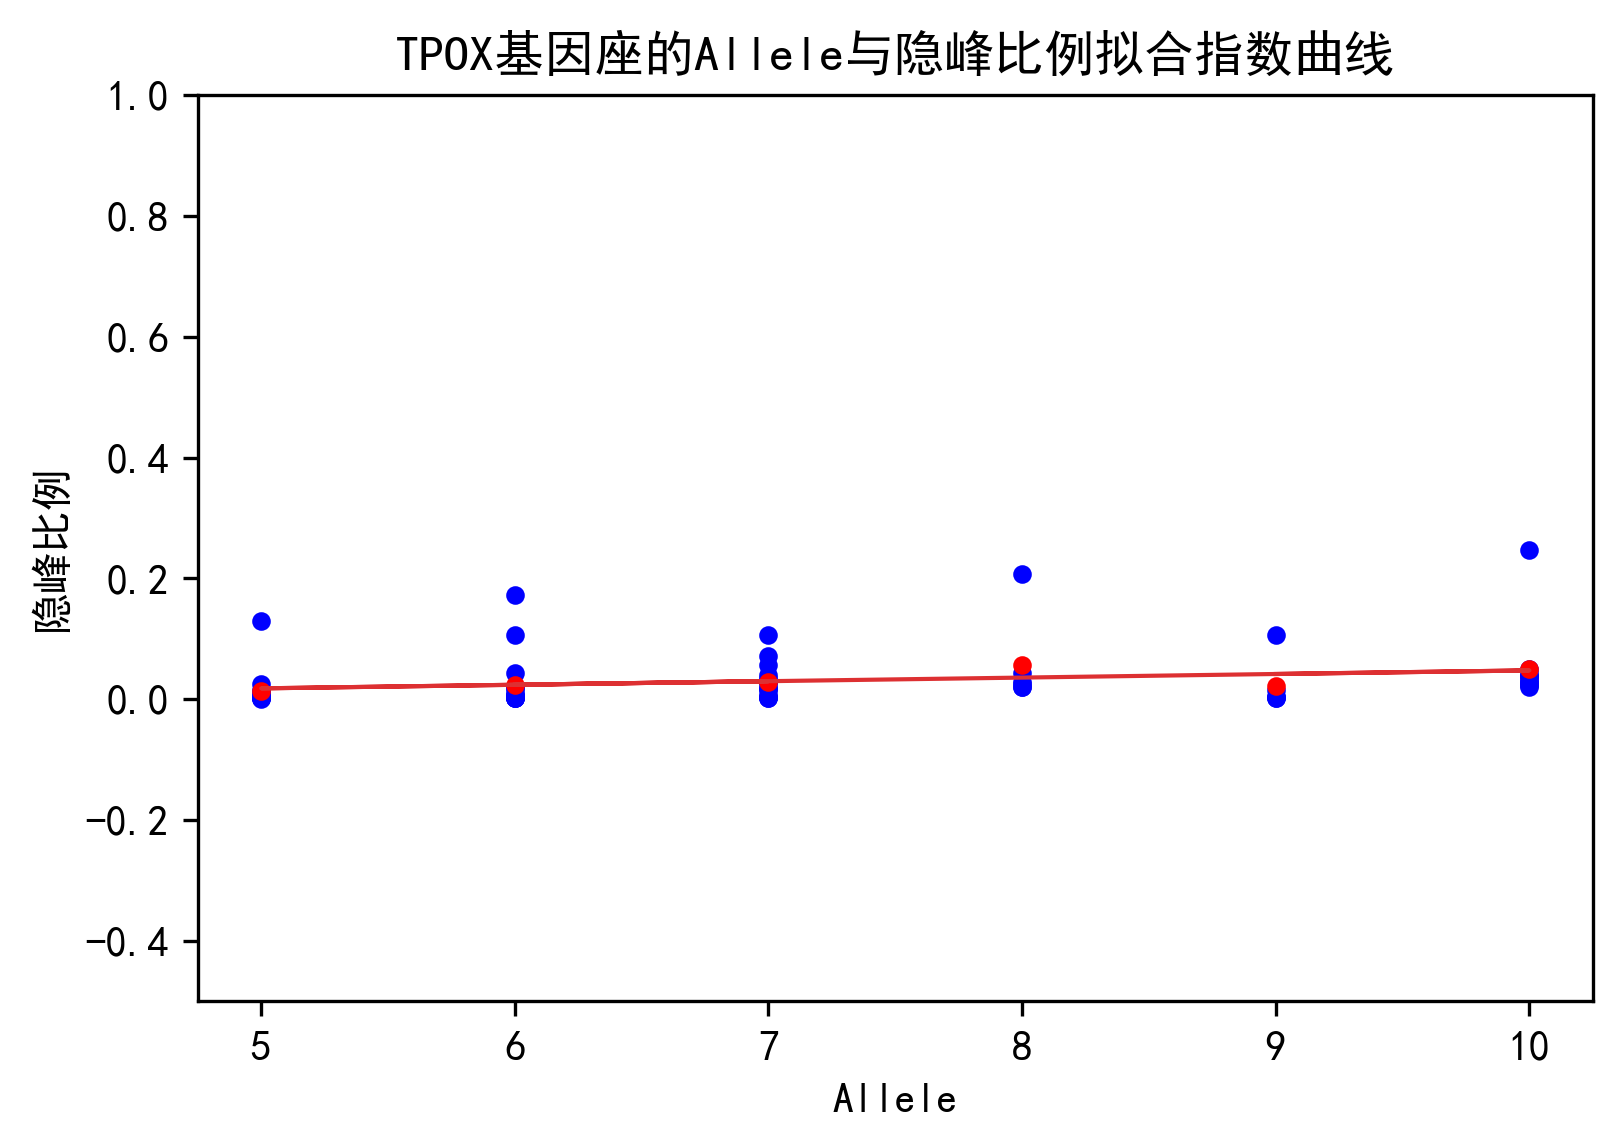

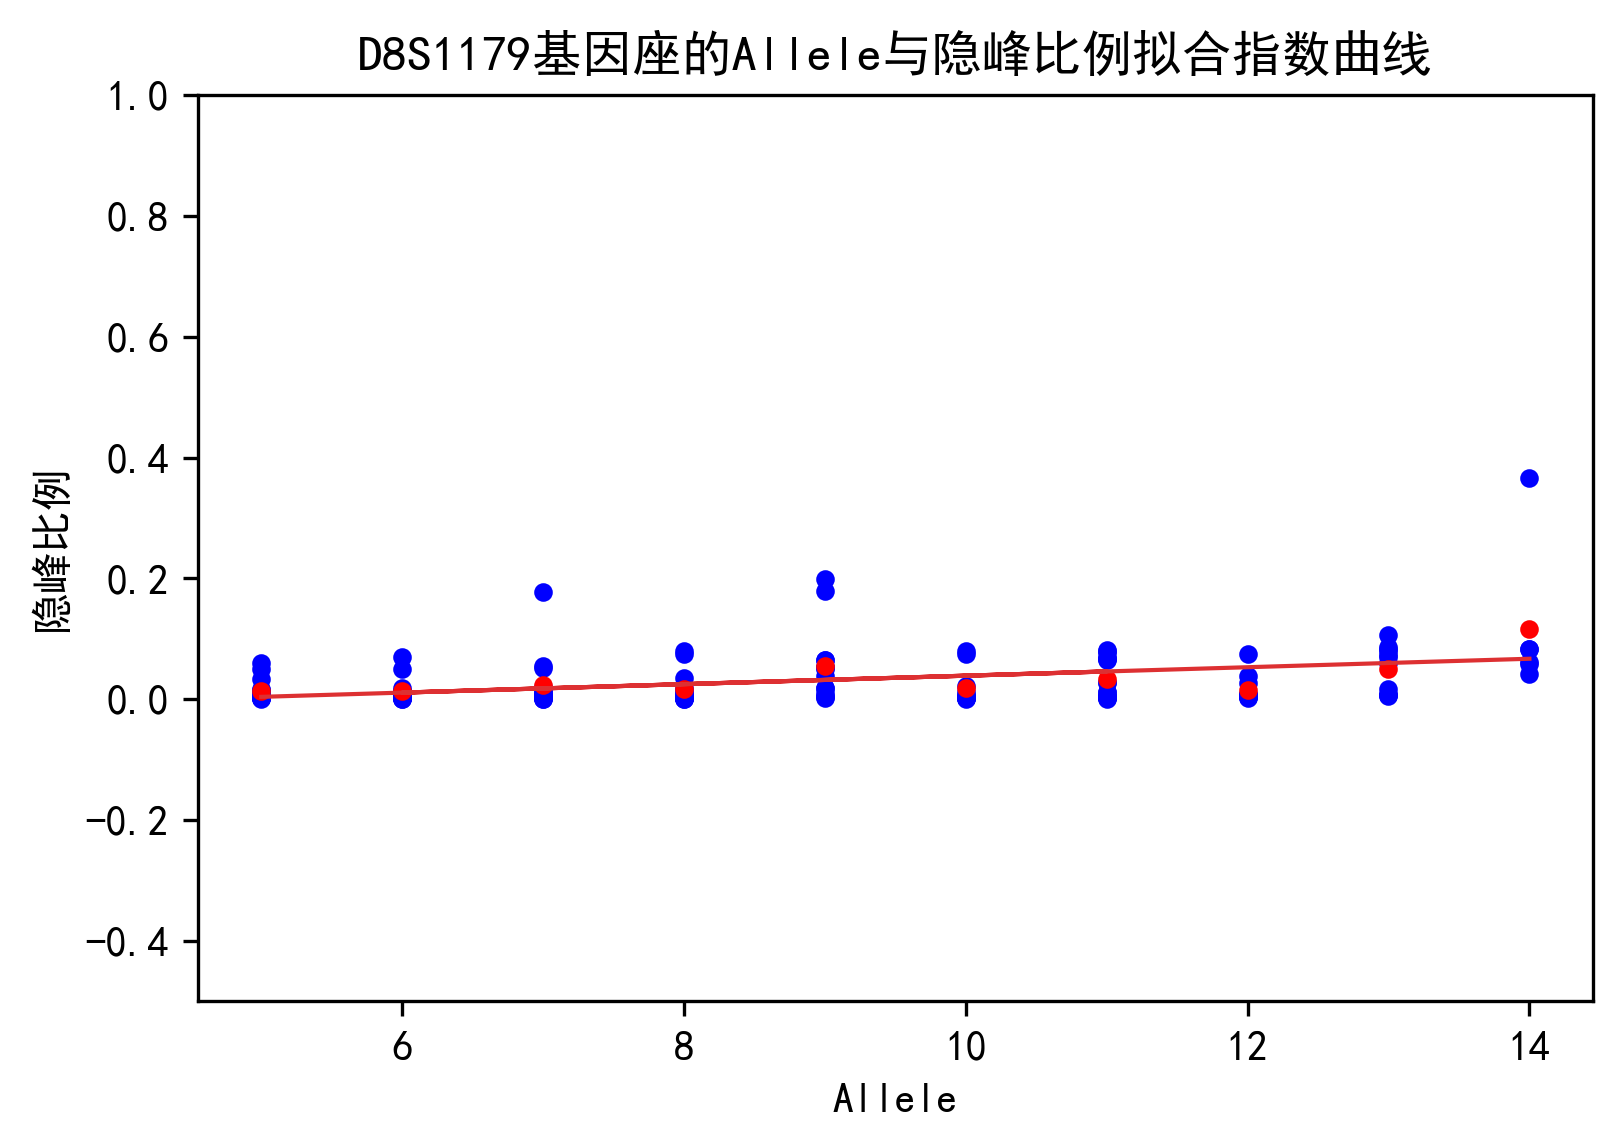

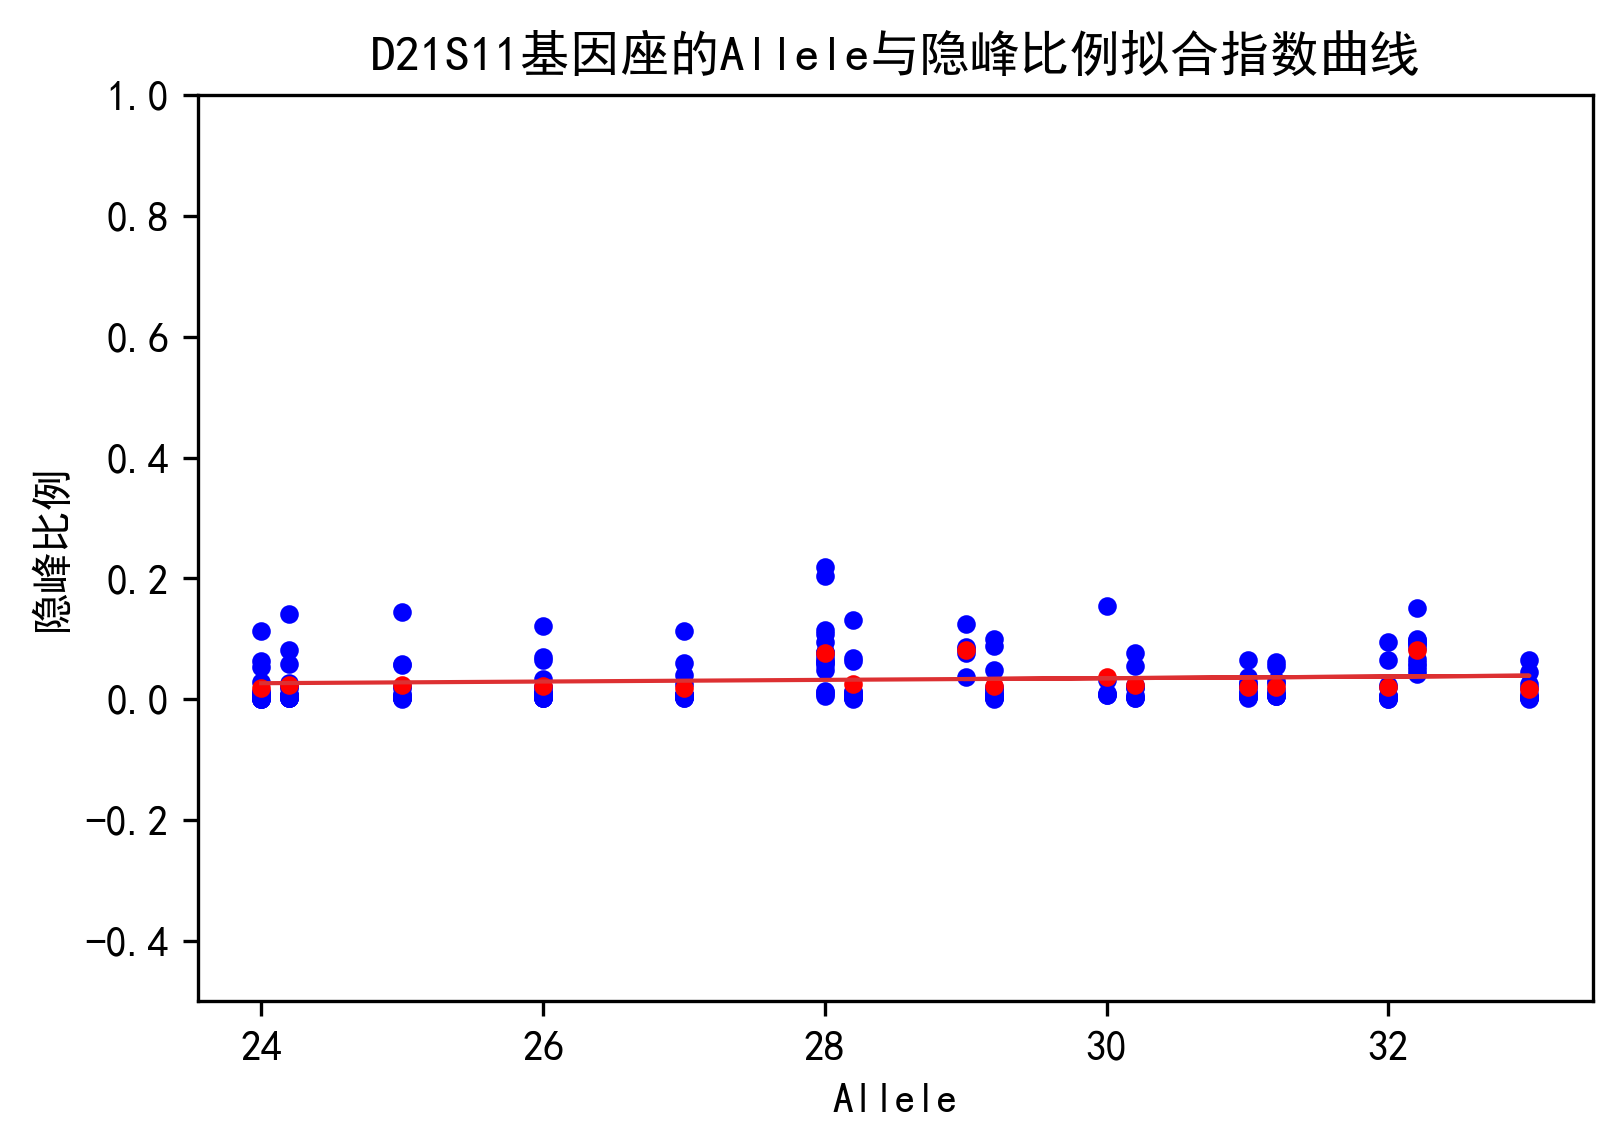

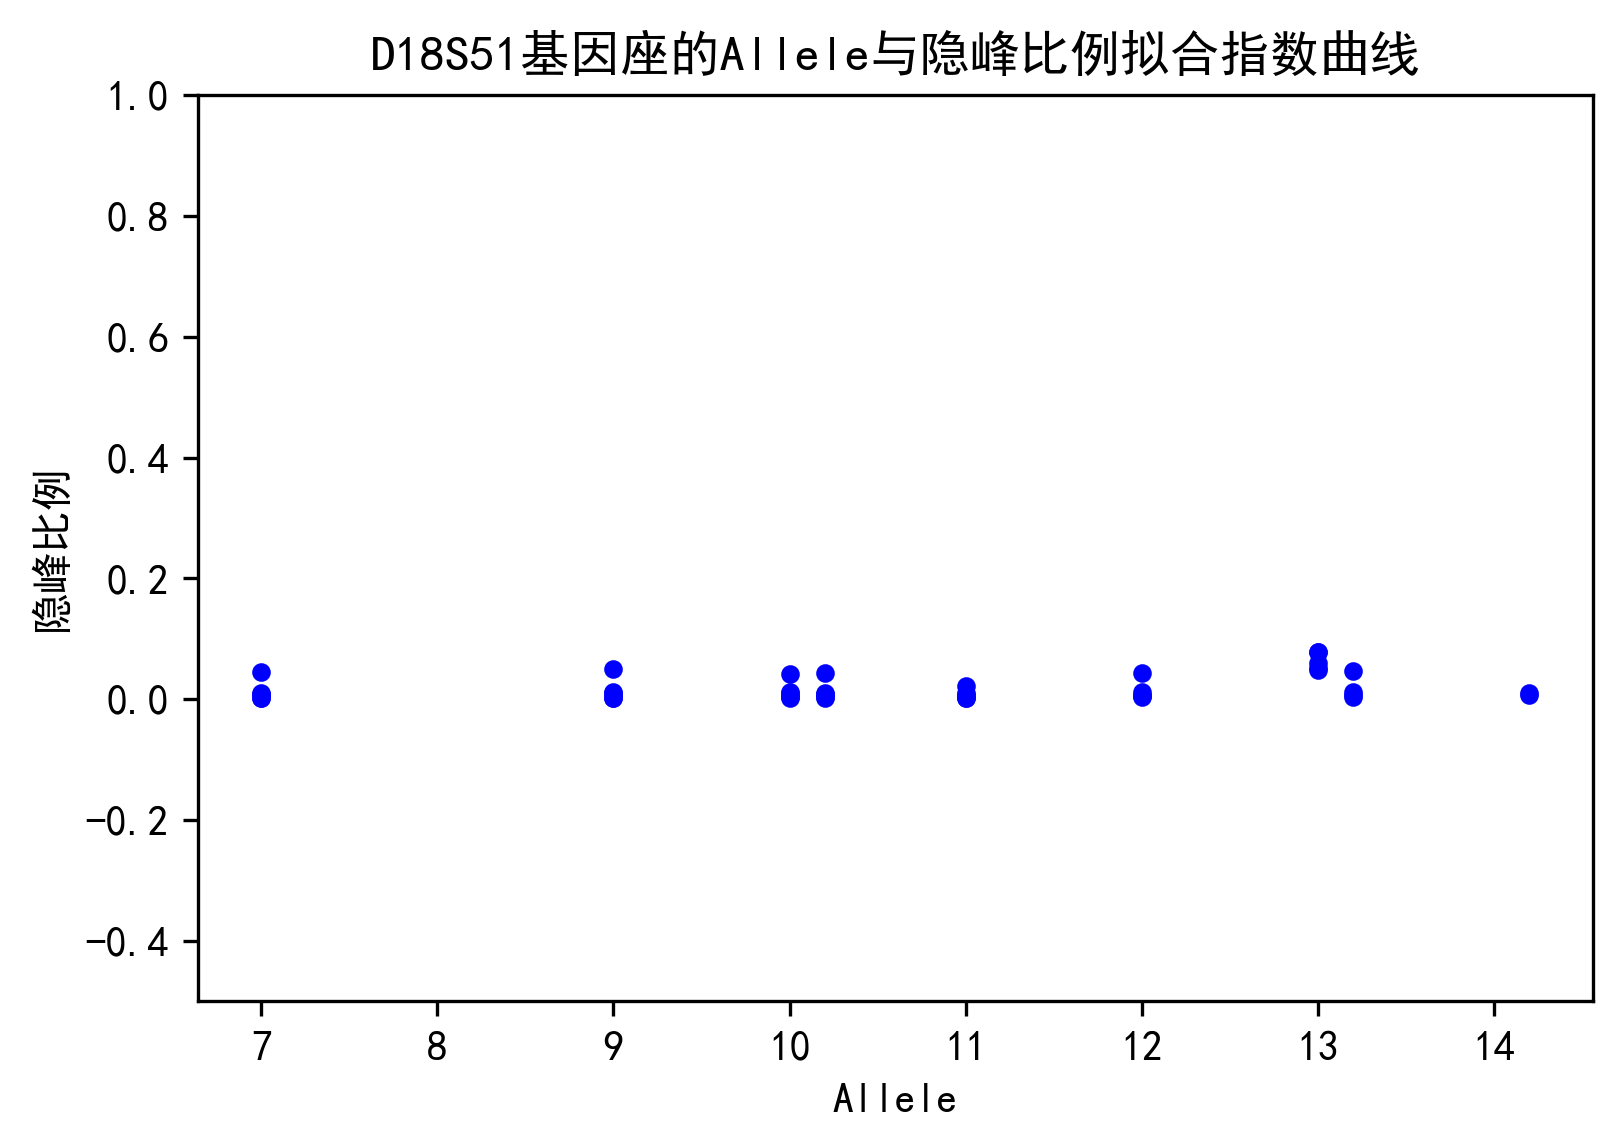

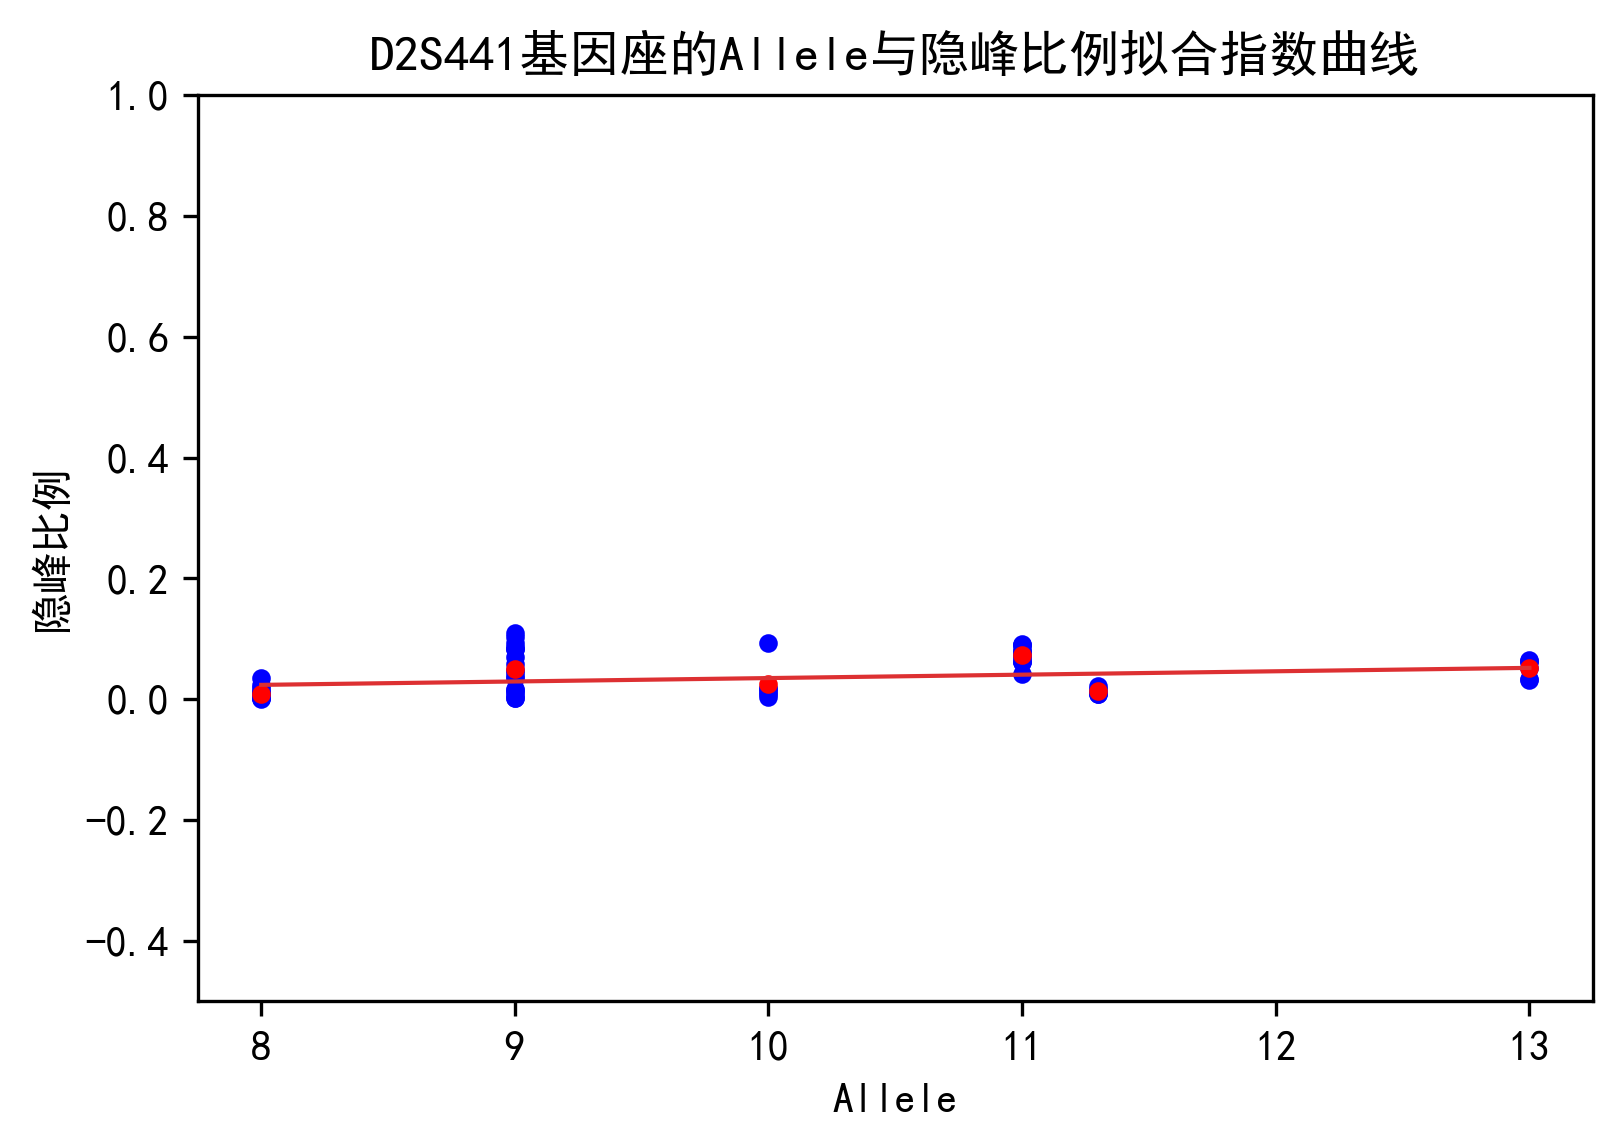

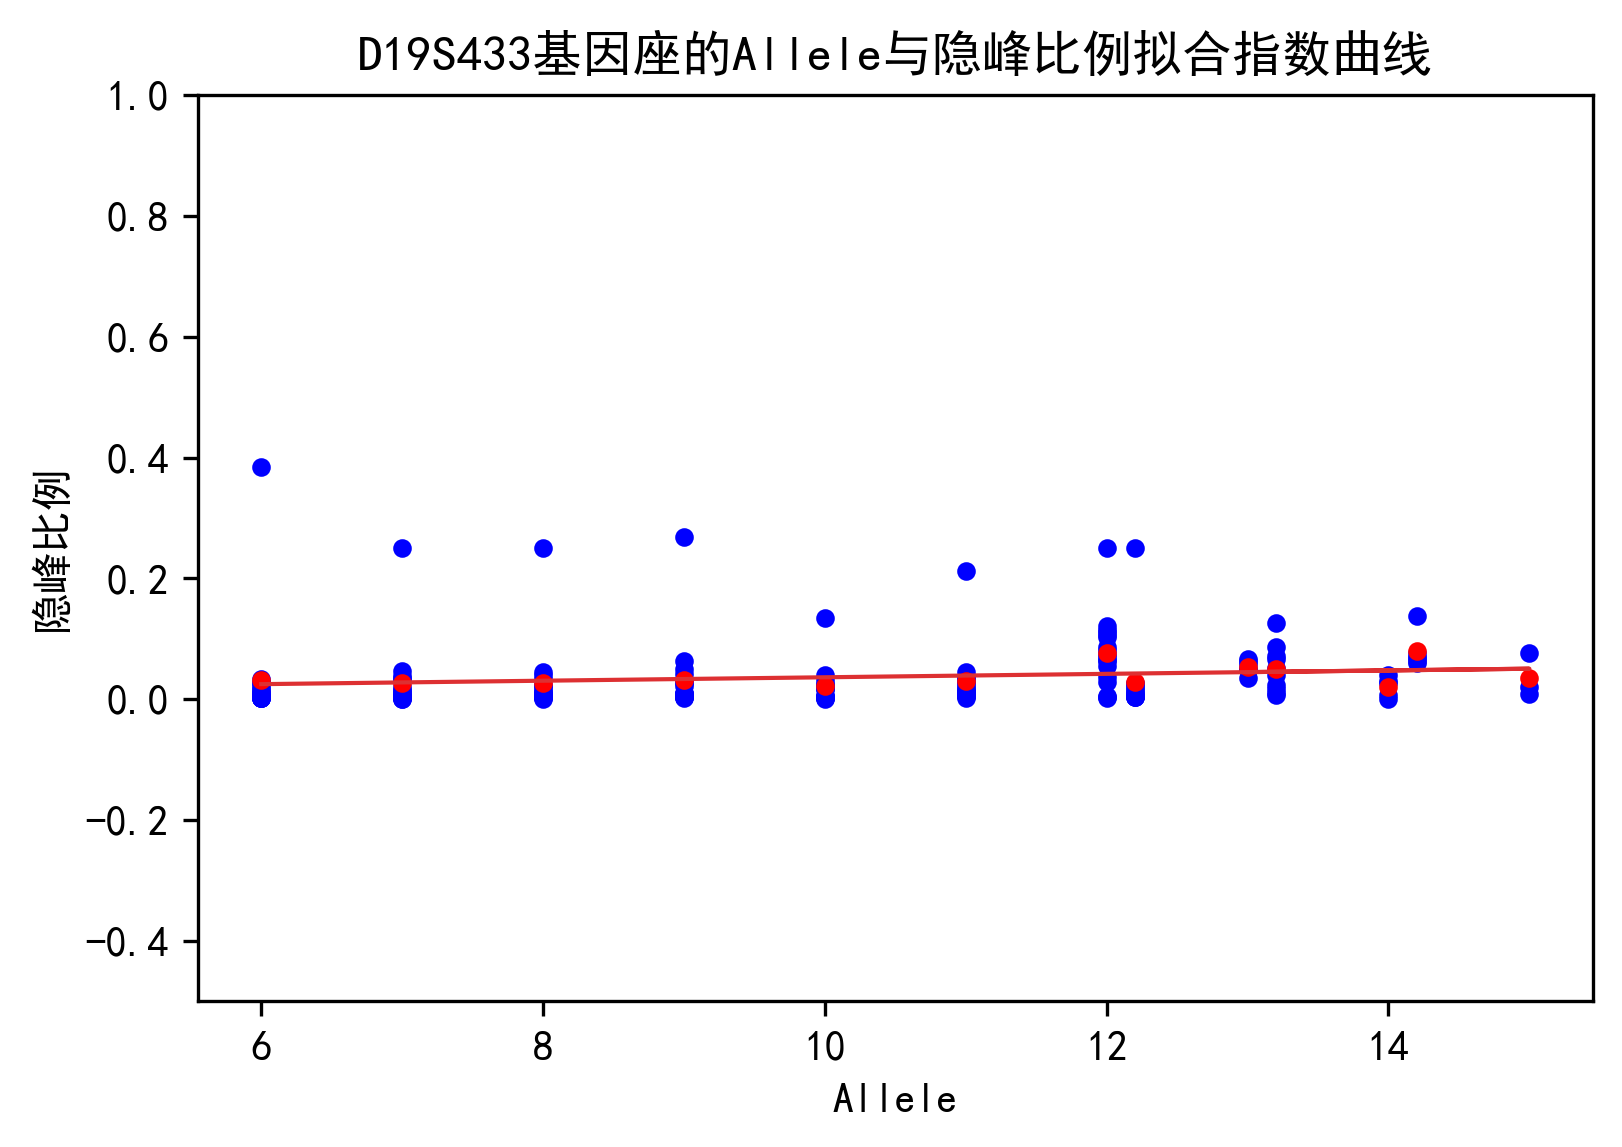

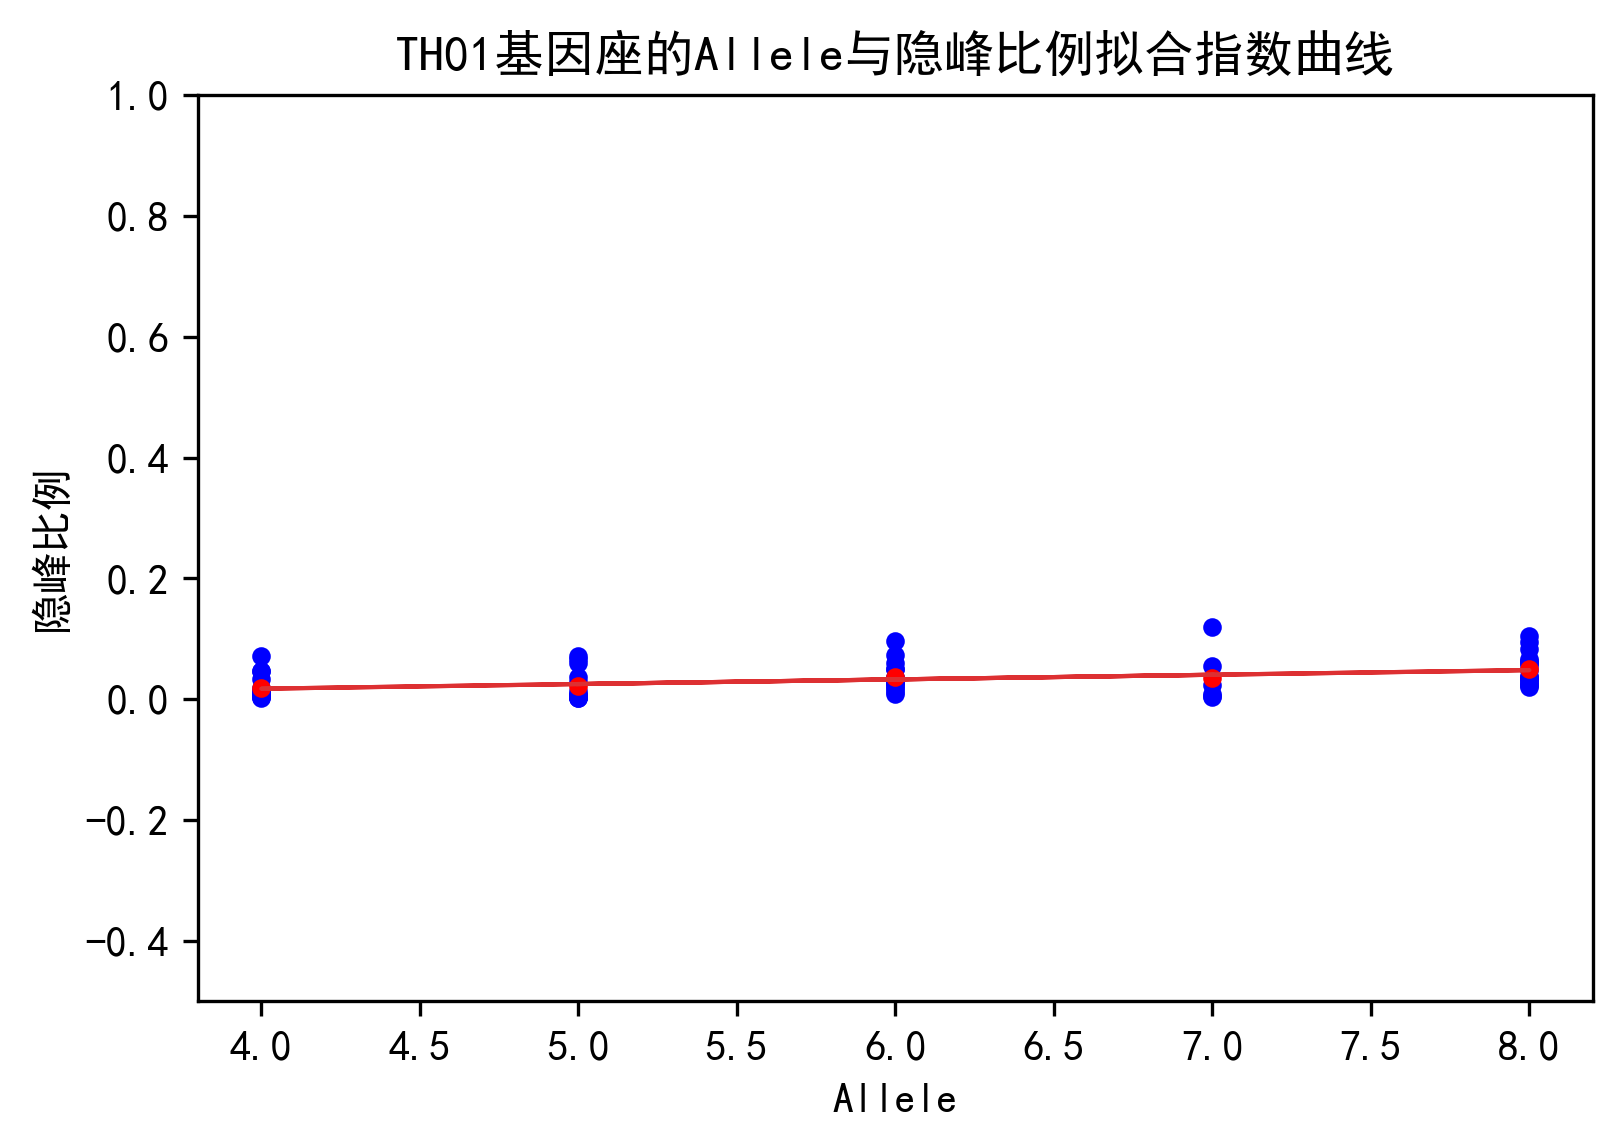

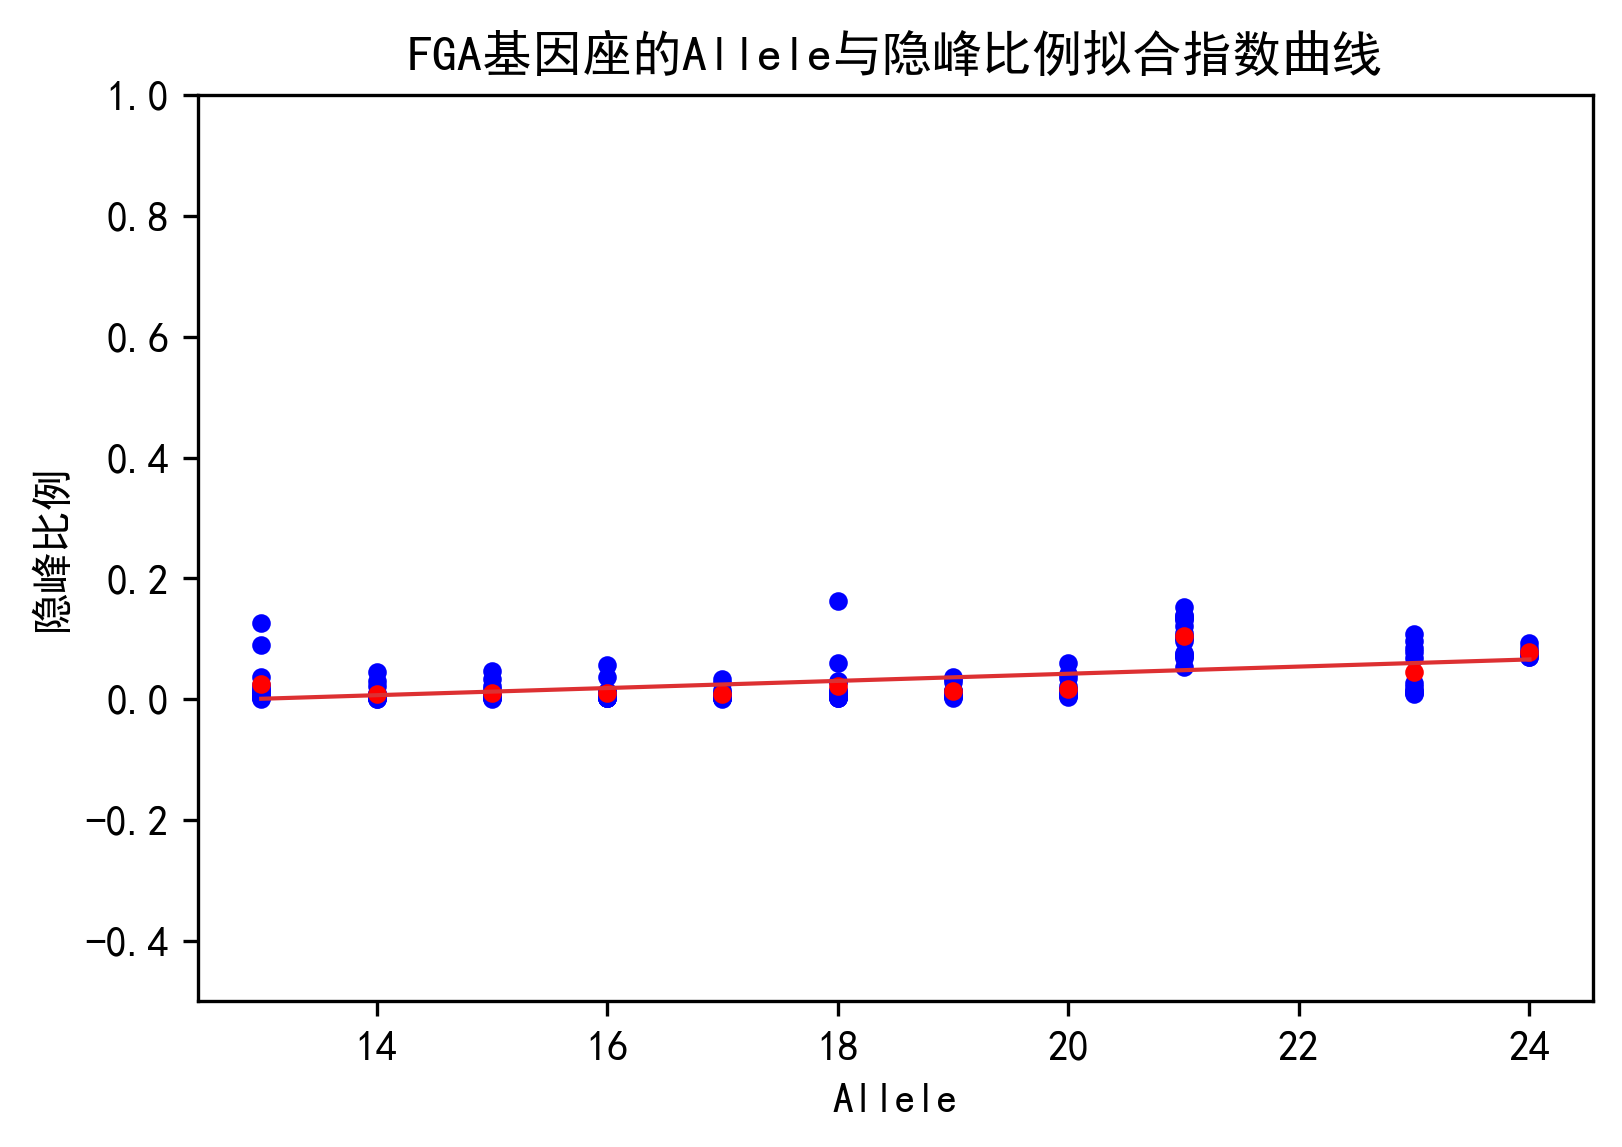

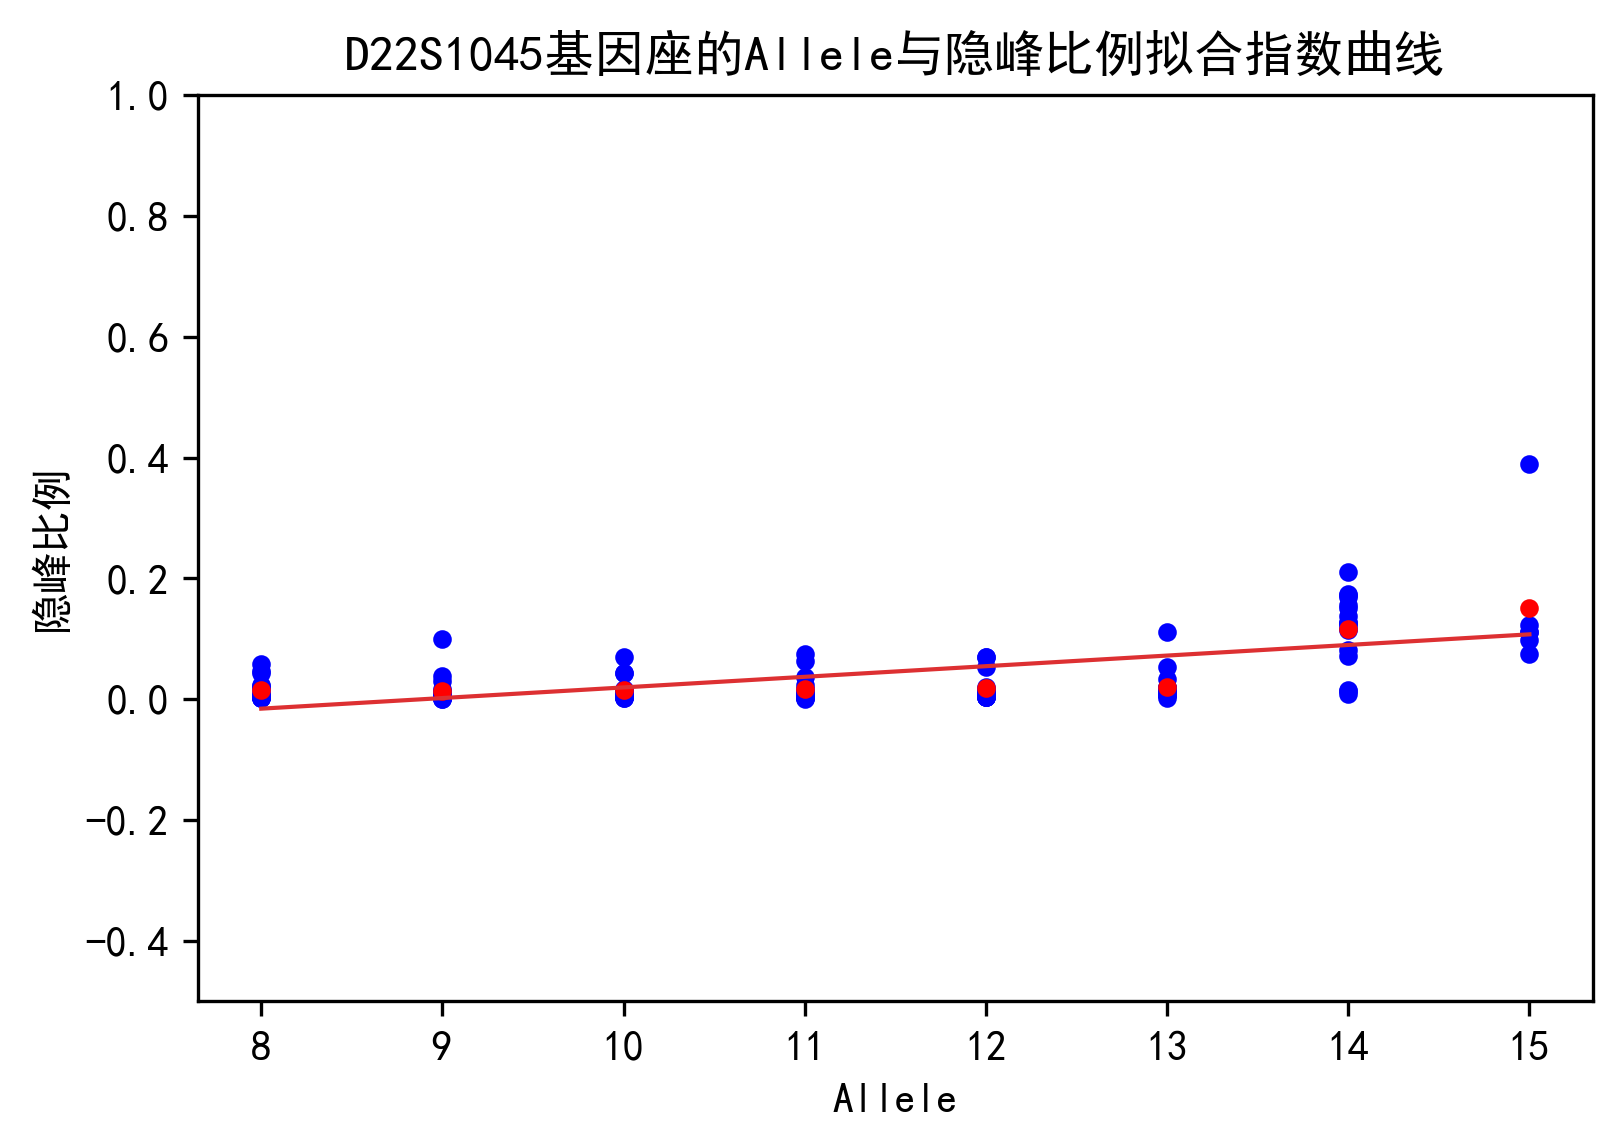

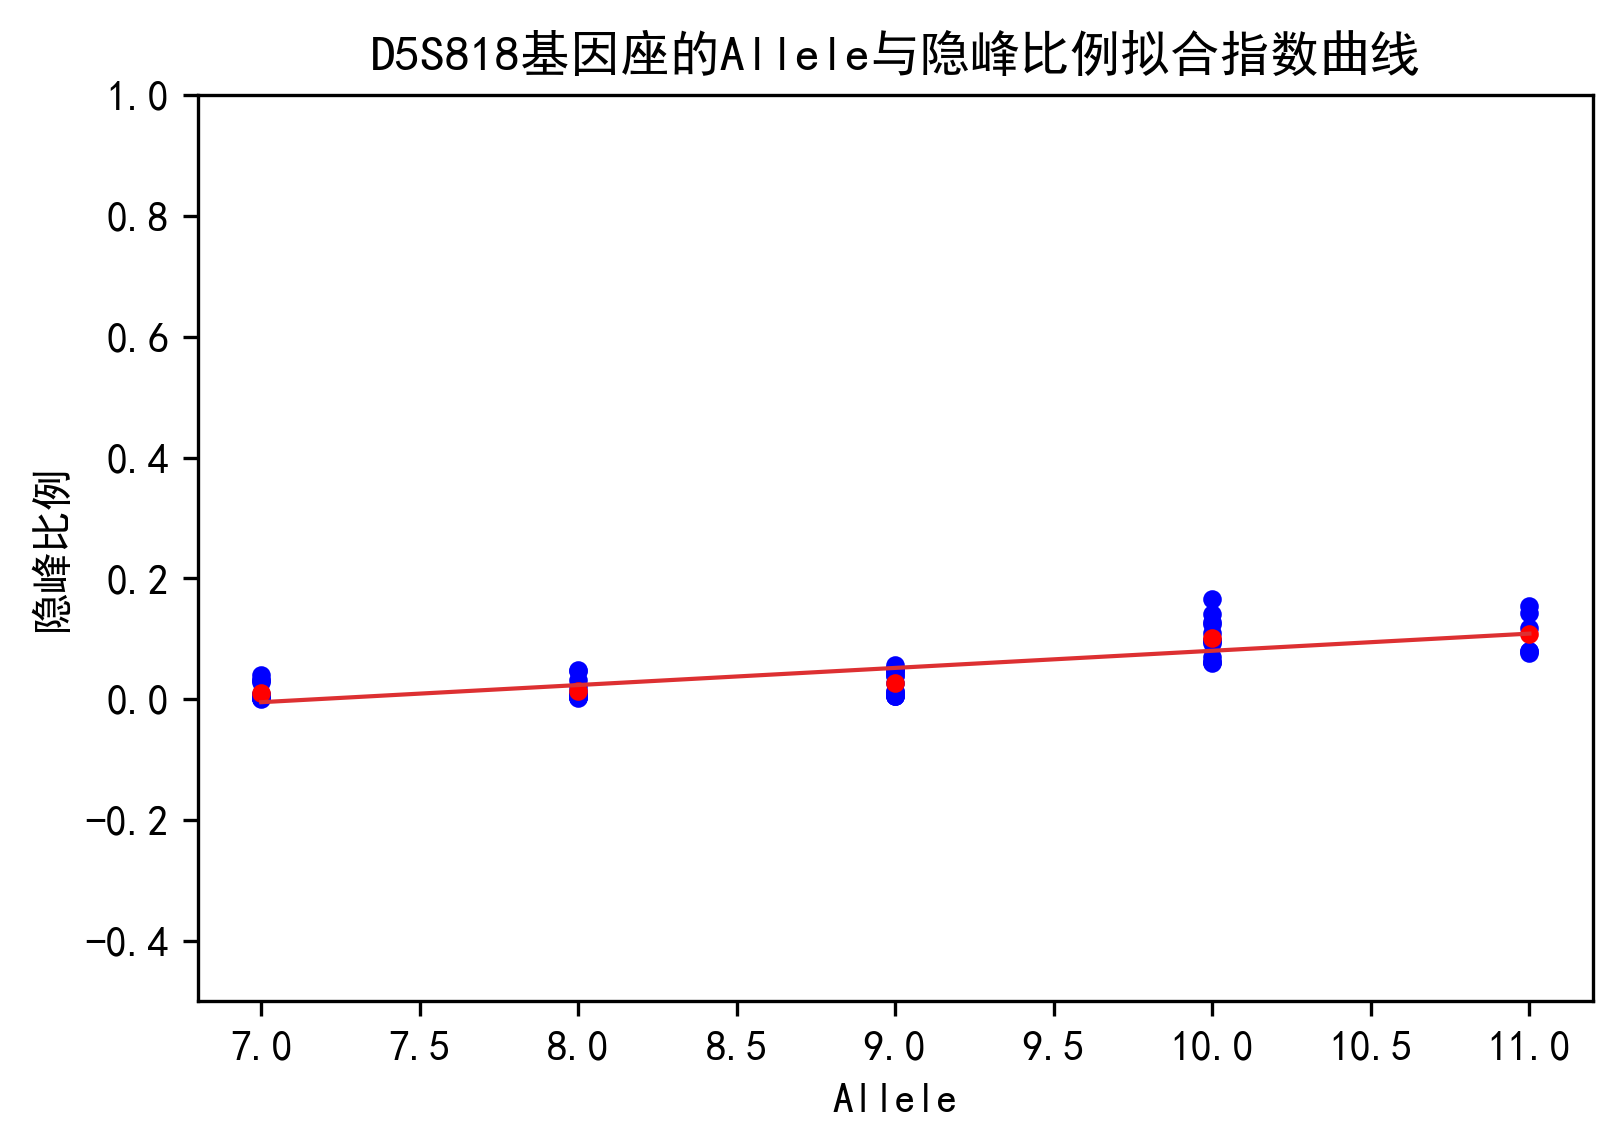

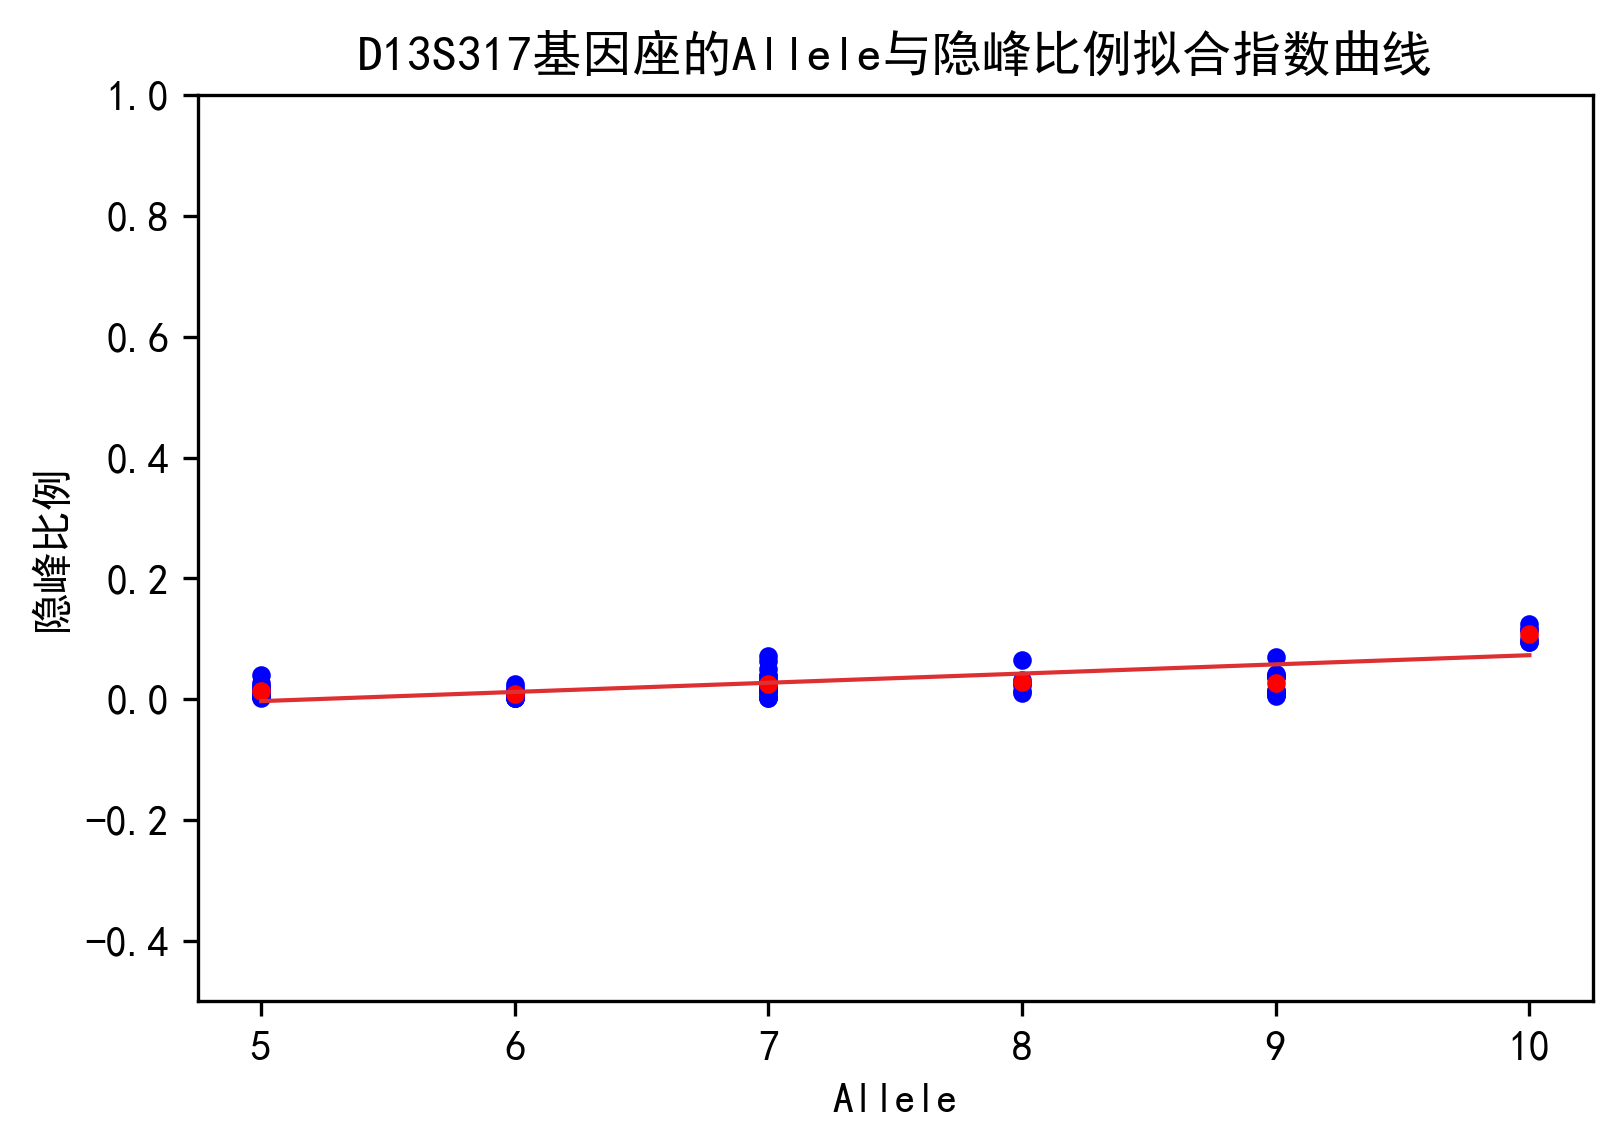

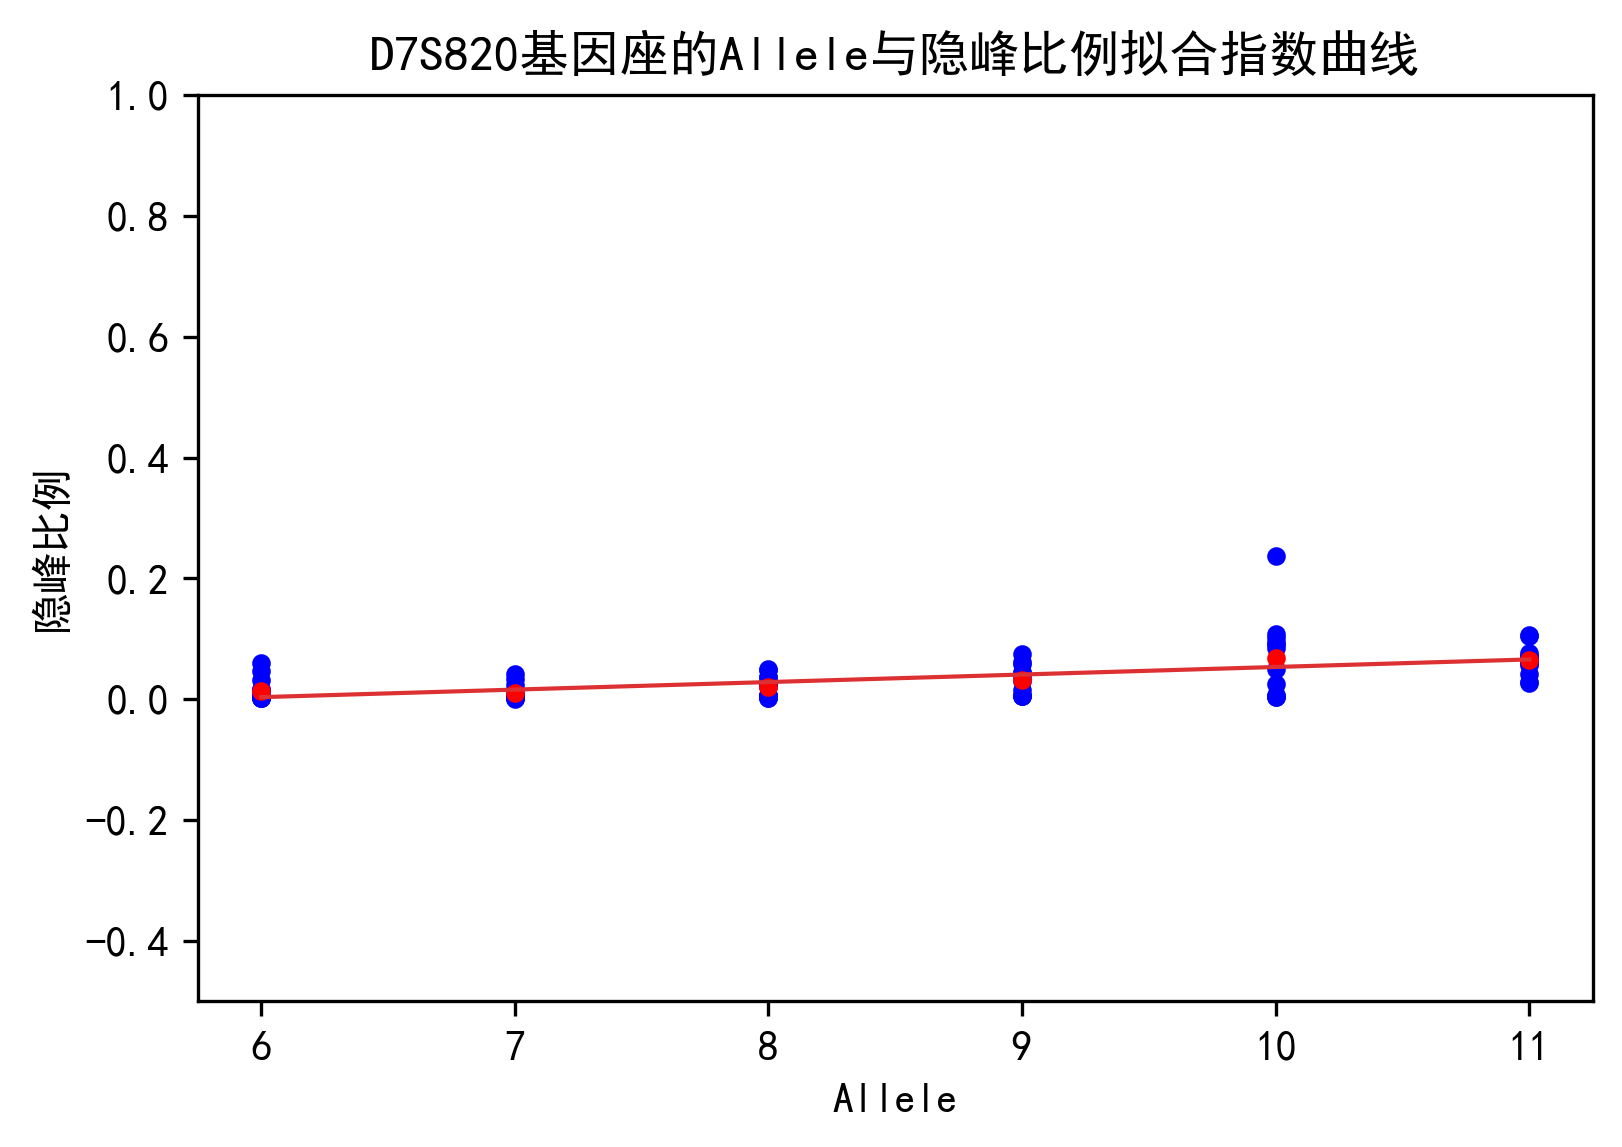

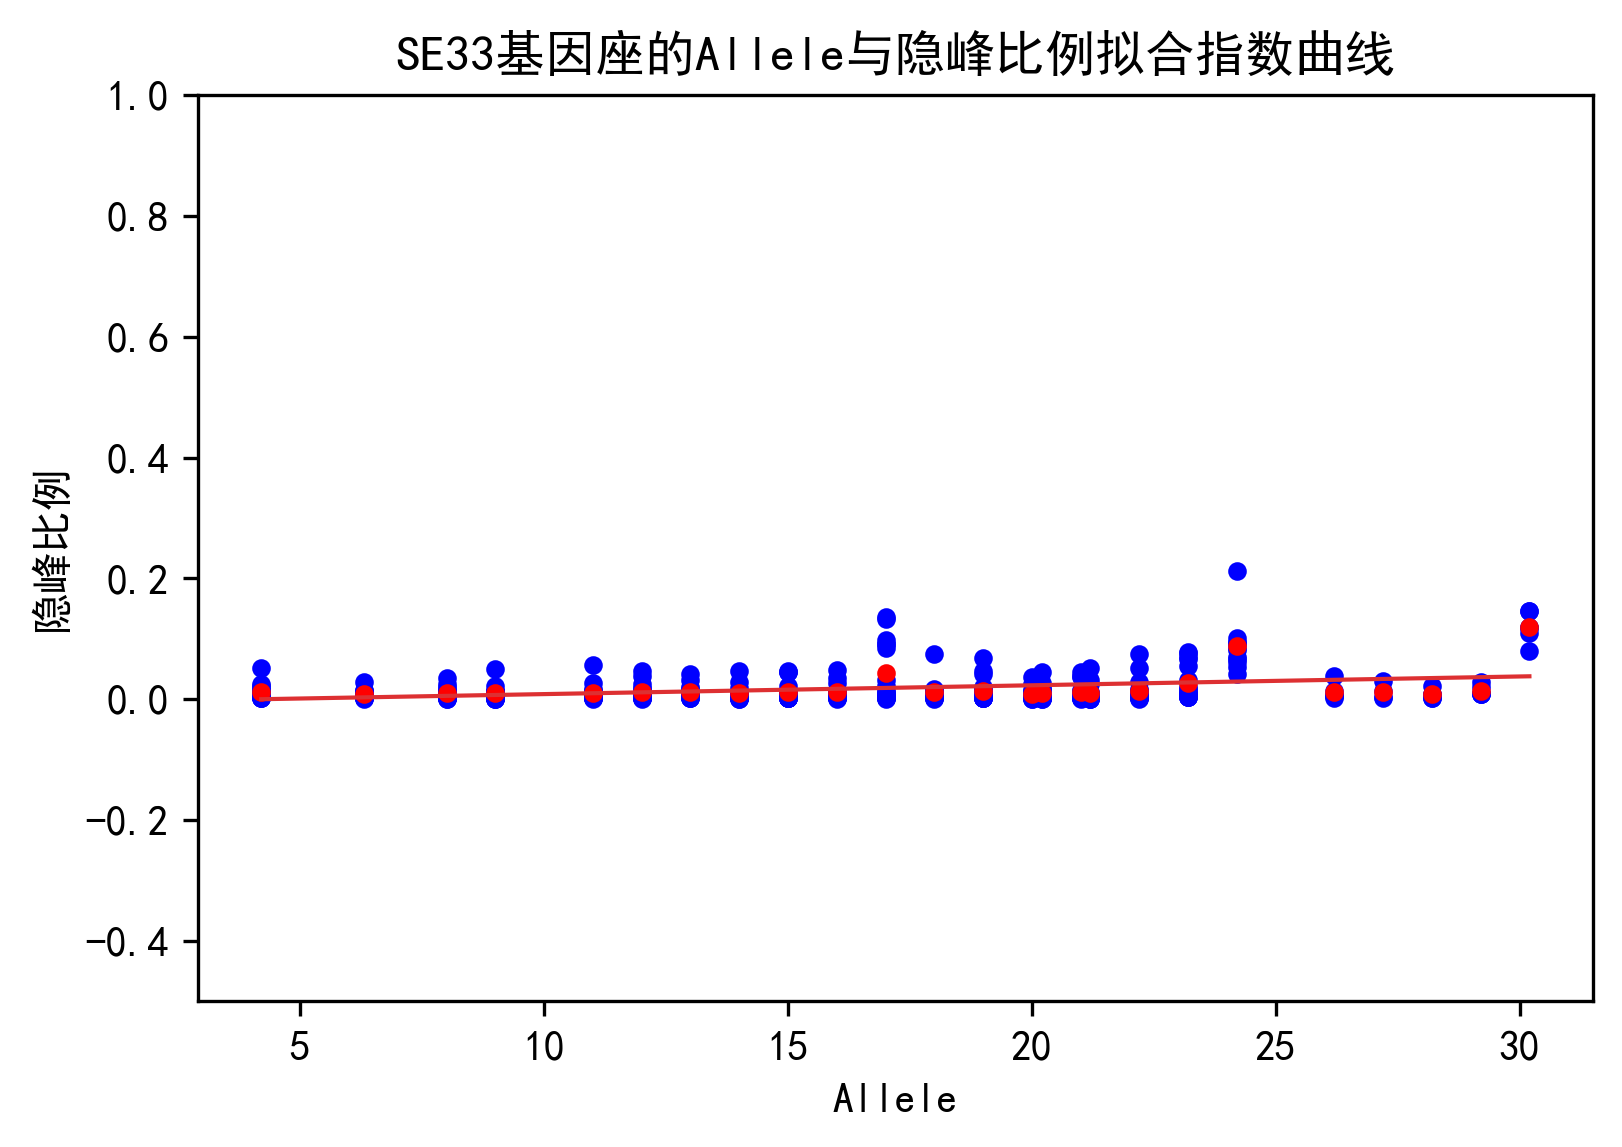

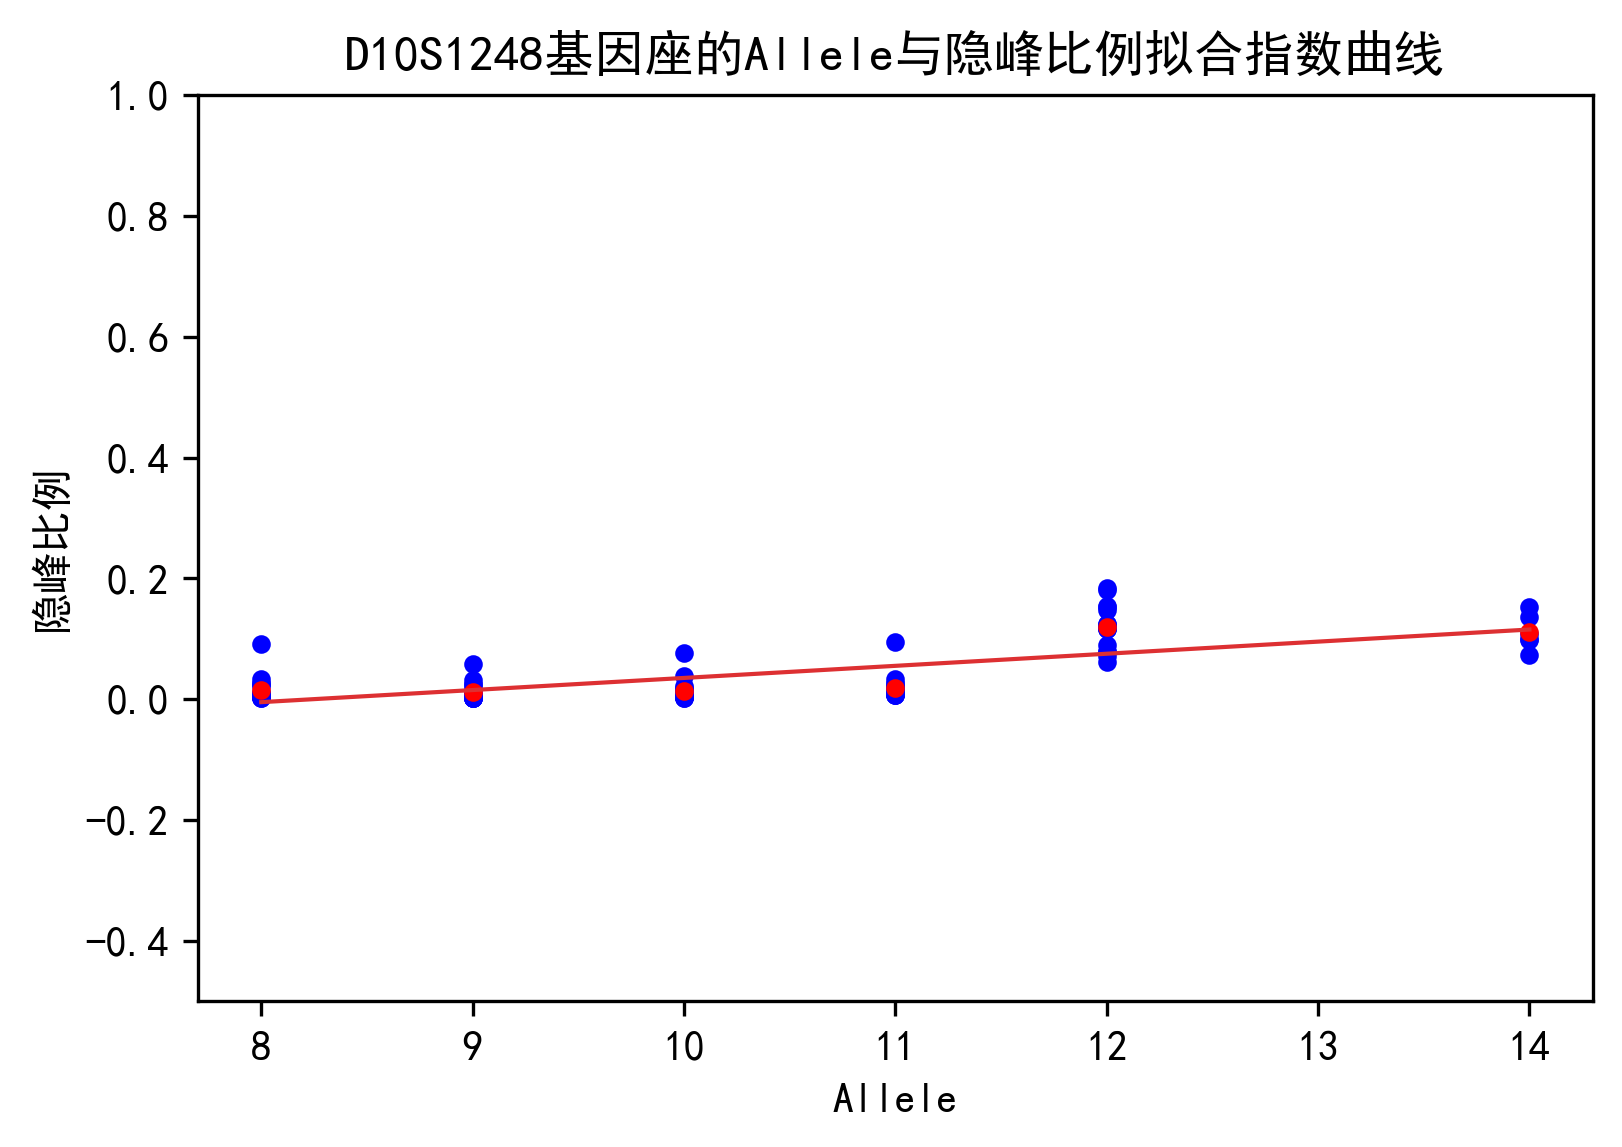

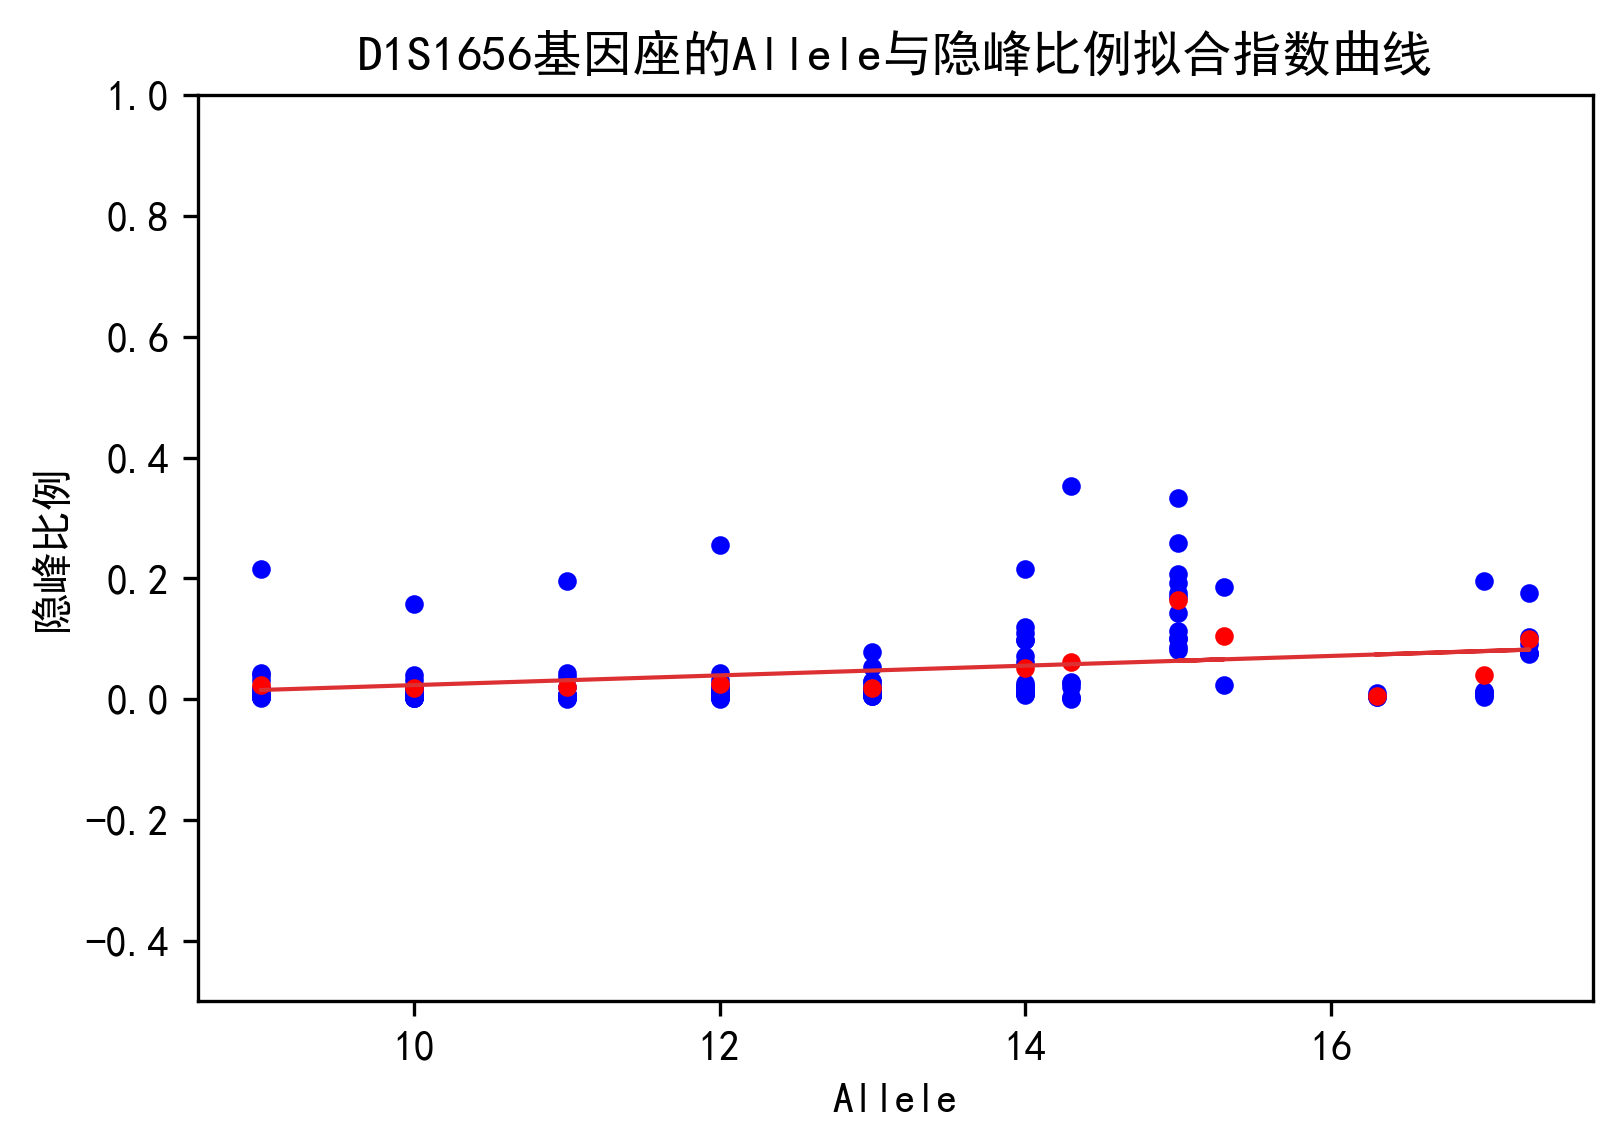

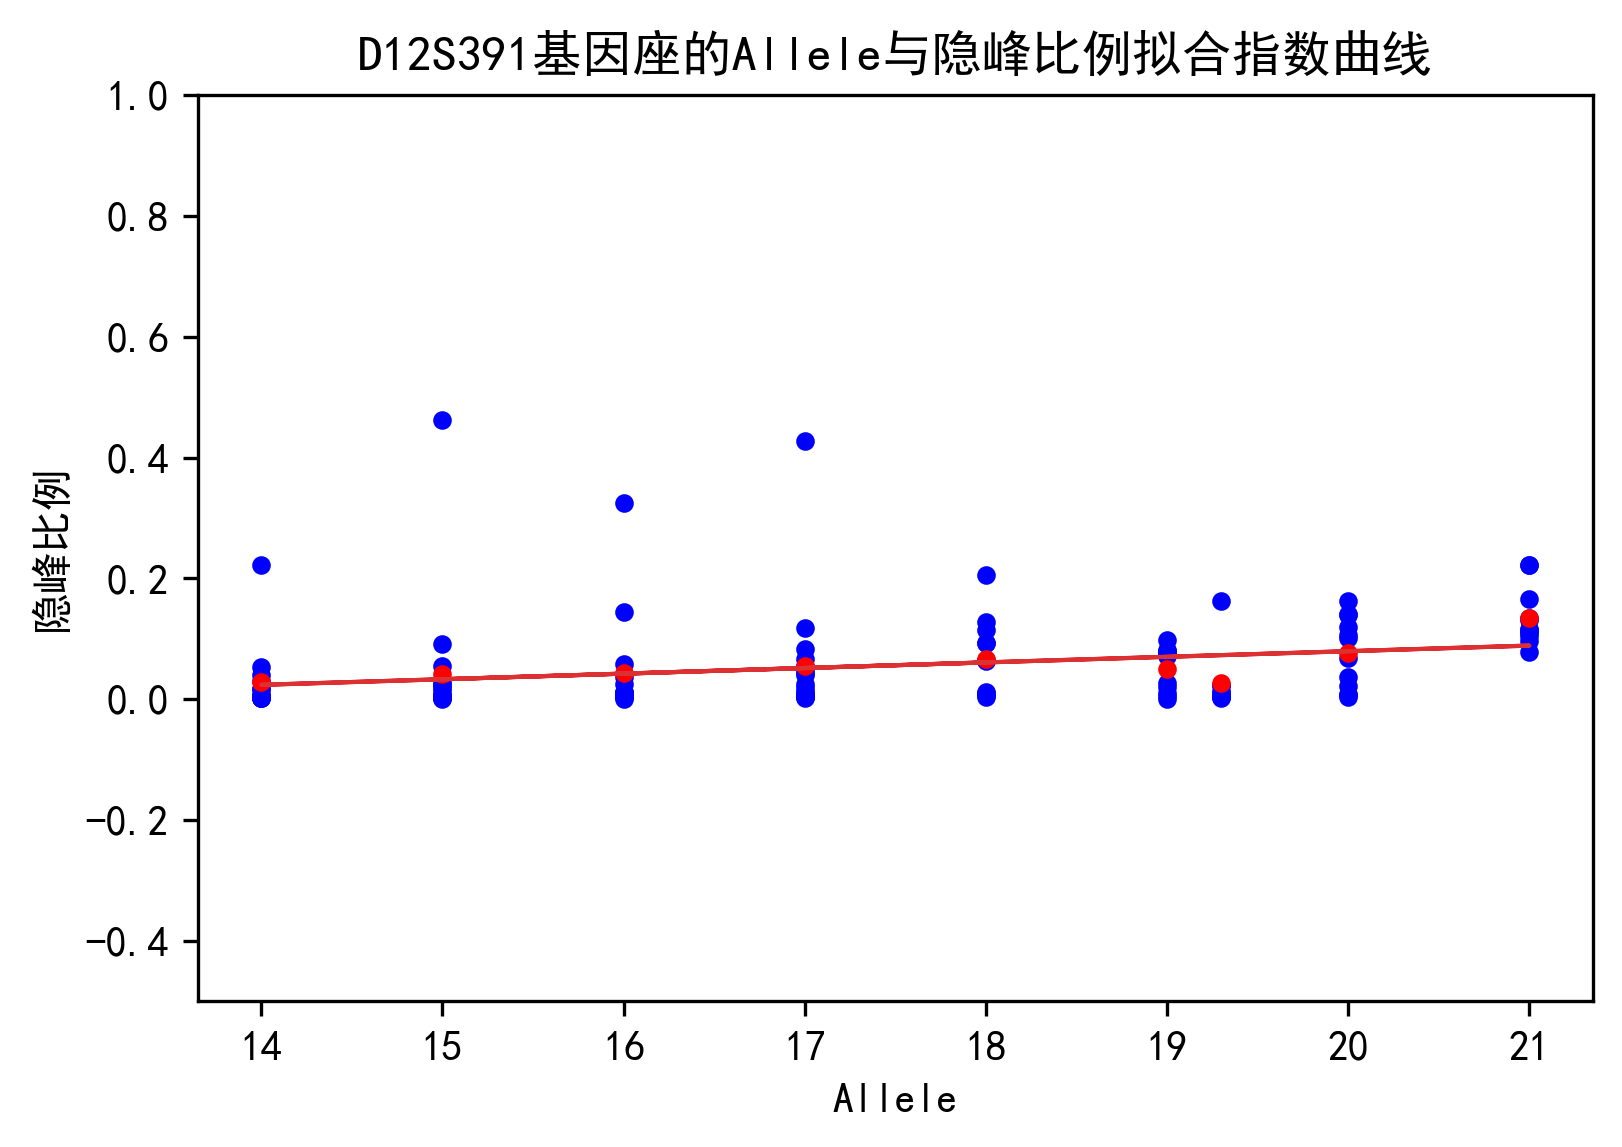

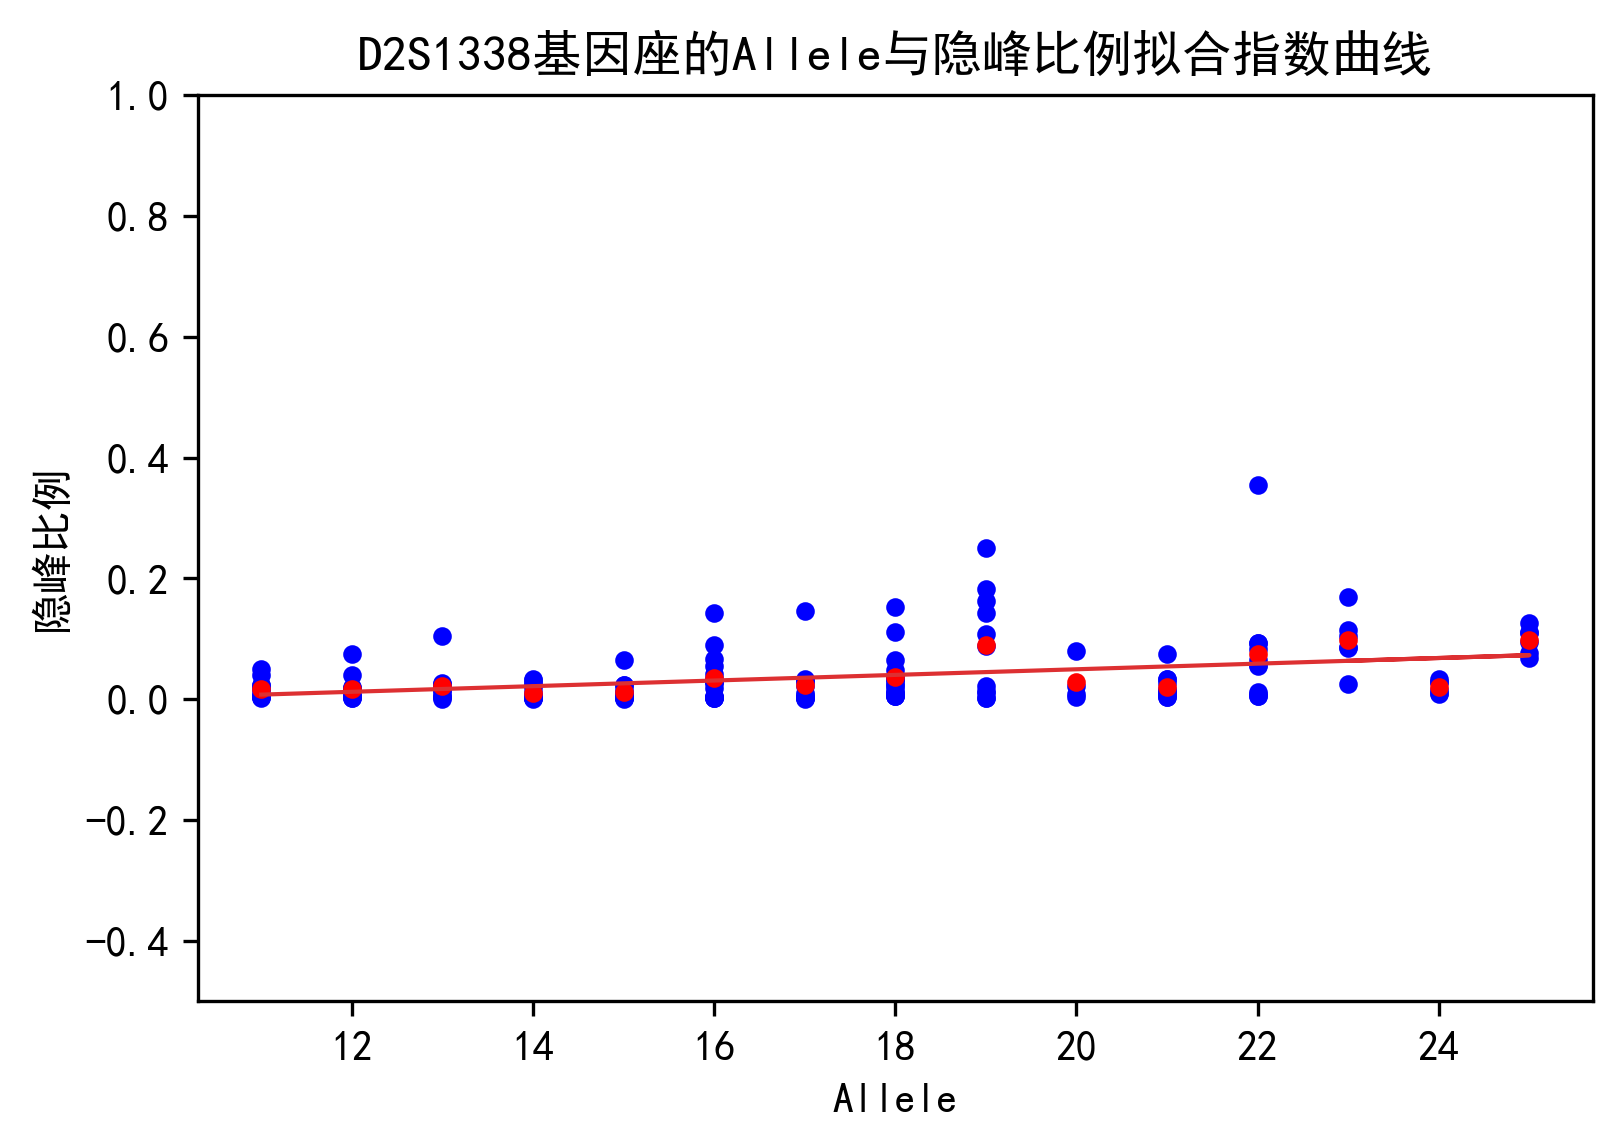

In [50]:
goal_data = {'基因座':[], '斜率':[], '截距':[], 'R2':[]}
radio_gate = 0.5


marker = list(alleles_dict_list[0].keys())[1] # *


matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['font.family']='sans-serif' #解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False



for marker in list(alleles_dict_list[0].keys()):
    try:
        plt.figure(dpi=300)
        plt.title(f'{marker}基因座的Allele与隐峰比例拟合指数曲线')
        plt.xlabel('Allele')
        plt.ylabel('隐峰比例')
        plt.ylim(-0.5, 1)
        all_data_dict = {}
        for index, person in enumerate(['A', 'B', 'C']):
            radio_list_list = []
            x_list = []
            y_list = []
            for num in nums:
                init_data = pd.read_csv(f'data/单个个体/{person}{num}pg.hid_Genotype.csv', usecols=['Marker', 'Allele', 'Height', 'Size'])
                init_data = init_data[(init_data['Size'] != 'Dropout') & ~(init_data['Marker'].isin(delete_list))]
                init_data['Height'] = init_data['Height'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
                init_data['Allele'] = init_data['Allele'].apply(pd.to_numeric, errors='coerce').fillna(0.0)
                # 获得每个基因座的数据
                marker_data = init_data[init_data['Marker'] == marker]
                # 获得每个基因座的所有等位基因
                alleles_list = marker_data['Allele'].values
                # 获得真实等位基因
                true_alleles = np.array(alleles_dict_list[index][marker], dtype=float) # *

                # 获得等位基因横坐标
                x = []
                # 获得真实高度
                if true_alleles[0] == true_alleles[1]:
                    for i in alleles_list:
                        if i < true_alleles[0]:
                            x.append(i)
                    true_height = marker_data[marker_data['Allele'] == true_alleles[0]]['Height'].values[0] / 2
                    height_list = marker_data[marker_data['Allele'].isin(x)]['Height'].values
                    radio_list = height_list / true_height

                if true_alleles[0] != true_alleles[1]:
                    for i in alleles_list:
                        if i < true_alleles[1] and  i != true_alleles[0]:
                            x.append(i)
                    true_height = (marker_data[marker_data['Allele'] == true_alleles[0]]['Height'].values[0] + marker_data[marker_data['Allele'] == true_alleles[1]]['Height'].values[0]) / 2
                    height_list = marker_data[marker_data['Allele'].isin(x)]['Height'].values
                    radio_list = height_list / true_height

                flag = []
                for i in range(len(radio_list)):
                    if radio_list[i] > radio_gate:
                        flag.append(i)
                radio_list = np.delete(radio_list, flag)
                radio_list_list.append(radio_list)
                x = np.delete(x, flag)
                plt.scatter(x, radio_list, color='blue', s=12)
                for i in range(len(x)):
                    # 判断是否有all_data_dict[x[i]]，若有，则追加，若没有则创建
                    if x[i] in all_data_dict.keys():
                        all_data_dict[x[i]].append(radio_list[i])
                    else:
                        all_data_dict[x[i]] = [radio_list[i]]


        # 绘制all_data_dict中的数据
        for key in all_data_dict.keys():
            x_list.append(key)
            y_list.append(np.mean(all_data_dict[key]))
        plt.scatter(x_list, y_list, color='red', s=12)
        model = LinearRegression()
        x = np.array(x_list).reshape(-1, 1)
        y = np.array(y_list).reshape(-1, 1)
        model.fit(x, y)
        plt.plot(x, model.predict(x), color='#dd3032', linewidth=1)
        goal_data['基因座'].append(marker)
        goal_data['斜率'].append(model.coef_[0][0])
        goal_data['截距'].append(model.intercept_[0])
        goal_data['R2'].append(model.score(x, y))
    except:
        pass

pd.DataFrame(goal_data).to_csv('img/直线/直线拟合参数.csv', index=False)
    # plt.savefig(f'img/直线/{marker}.png')
goal_data

In [51]:
list(alleles_dict_list[0].keys())[0]

'D3S1358'